# **Setup**


---



In [ ]:
pip install transformers

In [ ]:
pip install sentencepiece

In [ ]:
pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 26.6 MB/s eta 0:00:00


In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=4e73cb64afb9044e21313e392039d17531764d6d14af17521306435ffce7bf57
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
from transformers import pipeline
from os import makedirs, path
import re
import fitz
from pandas import DataFrame
from langdetect import detect
from collections import defaultdict
from os import scandir, listdir

In [ ]:
def extract_text(doc) -> str:
    document_text = ''
    for page in doc:
        page_blocks = page.get_text('blocks', sort=False, flags=fitz.TEXTFLAGS_SEARCH & fitz.TEXT_DEHYPHENATE & ~fitz.TEXT_PRESERVE_IMAGES)
        page_text = ''
        for block in page_blocks:
            block_text = block[4]
            block_text = block_text.replace('\n', ' ').strip()
            page_text += block_text + '\n'
        page_text = re.sub(pattern=r'([a-zA-Z0-9 ])(\n+)([A-Z])', repl=r'\1. \2\3', string=page_text)
        page_text = re.sub(pattern=r'([^.])(\n)([^A-Z])', repl=r'\1 \3', string=page_text)
        page_text = re.sub(pattern=r' +', repl=' ', string=page_text)
        document_text += page_text + '\n\n'
    document_text = re.sub(pattern=r'\n{3,}', repl=r'\n\n\n', string=document_text)
    return document_text.strip()

In [ ]:
def text_loader(report_data, analyze_language=True):
    for companyName, reports in report_data.items():
        print('\nCOMPANY:', companyName)
        for idk, url_report in enumerate(reports):
            try:
                with fitz.open(url_report['path']) as doc:
                    document_text = extract_text(doc)
                    document_text = document_text.encode('utf-8', errors='replace').decode('utf-8')
                    is_duplicated_text = any([doc['text'] == document_text for doc in report_data[companyName] if 'text' in doc.keys() and doc['text'] != None])
                    if is_duplicated_text:
                        print("Duplicate text")
                        continue
                    report_data[companyName][idk]['numPages'] = doc.page_count
                    report_data[companyName][idk]['text'] = document_text
                    if analyze_language:
                        predicted_language = detect(text=document_text.replace("\n", " "))
                        report_data[companyName][idk]['language'] = predicted_language['lang']
                    print(f'--> REPORT {idk + 1}/{len(reports)}: [{doc.metadata["format"]}| PAGES:{doc.page_count}] \'{url_report["documentType"]}\'')
            except RuntimeError as runtime_error:
                print(f'\t--> ERROR: {runtime_error}')
                report_data[companyName][idk]['text'] = None
    return report_data


In [ ]:
def save_textual_data(report_data, saving_folder):
    for companyName, reports in report_data.items():
        for report in reports:
            if 'text' not in report.keys() or report['text'] == None:
                continue
            year_folder = path.join(saving_folder, report['year'])
            if not path.exists(year_folder):
                makedirs(year_folder)
            file_name = f"{companyName}-{report['documentType']}-{'-' + report['language'].upper() if 'language' in report else ''}.txt"
            with open(path.join(year_folder, file_name), mode='w', encoding='utf-8') as txt_file:
                try:
                    txt_file.write(report['text'])
                except UnicodeEncodeError as unicode_error:
                    print(f'\t--> ERROR: {unicode_error}')
                    report['text'] = report['text'].encode('utf-8', errors='replace').decode('utf-8')
                    txt_file.write(report['text'])


In [ ]:
def num_pages_stats(saving_folder, report_data):
    df = DataFrame([report['numPages'] for reports in report_data.values() for report in reports if 'numPages' in report], columns=['numPages'])
    df = df.describe()
    df.to_excel(path.join(saving_folder, 'numPages.xlsx'))
    return df

In [ ]:
def file_metadata_loader(file_path):
    file_name = path.basename(file_path)
    document_name, file_extension = path.splitext(file_name)
    if file_extension.lstrip('.') not in ['pdf', 'txt', 'html', 'xhtml']:
        print(f'WARNING! Unsupported file extension for file "{file_name}".')
        return None
    partial_components = document_name.split('-')
    if len(partial_components) < 2 or len(partial_components) > 3:
        print(f'ERROR: The file name "{file_name}" is not in the correct format! <companyName>-<documentType>[-<documentLanguage>]')
        return None
    company_name = partial_components[0]
    document_type = partial_components[1]

In [ ]:
def process_file(company_name, year, file_path, analyze_language=True):
    try:
        with fitz.open(file_path) as doc:  # type: ignore
            document_text = extract_text(doc)
            document_text = document_text.encode('utf-8', errors='replace').decode('utf-8')

            if analyze_language:
                language = detect(text=document_text.replace("\n", " "))
            else:
                language = None

            sentences = re.split(r'(?<=[.!?]) +', document_text)
            data = {
                'company_name': company_name,
                'year': year,
                'num_pages': [doc.page_count] * len(sentences),
                'language': [language] * len(sentences),
                'file_path': [file_path] * len(sentences),
                'statements': sentences
            }
            return pd.DataFrame(data)
    except RuntimeError as runtime_error:
        print(f'\t--> ERROR: {runtime_error}')
        return None

In [ ]:
class ZeroShotClassifier:

    def create_zsl_model(self, model_name, batch_size):

        self.model = pipeline("zero-shot-classification", model=model_name, device=0, batch_size=batch_size)


    def classify_text(self, text, categories):

        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result


    def text_labels(self, text, category_dict, cutoff=None):

        categories = list(category_dict.keys())
        result = (self.classify_text(text, categories))

        label = result['labels'][0]
        score = result['scores'][0]

        return label, score

In [ ]:
model_name = "facebook/bart-large-mnli"
batch_size = 20

ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_name, batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
labels = {
    0: "Waste And Hazardous Materials Management",
    1: "Water And Wastewater Management",
    2: "Air Quality",
    3: "Ecological Impacts",
    4: "Energy Management",
    5: "GHG Emissions",
    6: "Customer Satisfaction",
    7: "Employee Engagement",
    8: "Employee Welfare",
    9: "Diversity and Inclusion",
    10: "Human Rights",
    11: "Labor Practices",
    12: "Community Relations",
    13: "Business Ethics",
    14: "Critical Incident Risk Management",
    15: "Product Quality And Safety",
    16: "Product Design And Lifecycle Management",
    17: "Supply Chain Management",
    18: "Board Structure"
}

In [ ]:
esg_categories = {
    "Waste And Hazardous Materials Management": "E",
    "Water And Wastewater Management": "E",
    "Air Quality": "E",
    "Ecological Impacts": "E",
    "Energy Management": "E",
    "GHG Emissions": "E",
    "Customer Satisfaction": "S",
    "Employee Engagement": "S",
    "Employee Welfare": "S",
    "Diversity and Inclusion": "S",
    "Human Rights": "S",
    "Labor Practices": "S",
    "Community Relations": "S",
    "Business Ethics": "G",
    "Critical Incident Risk Management": "G",
    "Product Quality And Safety": "G",
    "Product Design And Lifecycle Management": "G",
    "Supply Chain Management": "G",
    "Board Structure": "G"
}

In [ ]:
reversed_labels = {v: k for k, v in labels.items()}

In [ ]:
def filter_sequences(df):

    filtered_df = df.drop_duplicates(subset='sequence', keep='first')

    return filtered_df

In [ ]:
def get_esg(label):
  esg = esg_categories[label]

  return esg

In [ ]:
def get_id(label):
  id = reversed_labels[label]

  return id

In [ ]:
def count_labels(df):

    df_label = df['label'].value_counts().reset_index()
    df_label.columns = ['label', 'count']
    df_label['year'] = df['year'].iloc[0]

    return df_label

In [ ]:
def count_esg(df):

    df_esg = df['esg'].value_counts().reset_index()
    df_esg.columns = ['esg', 'count']
    df_esg['year'] = df['year'].iloc[0]

    return df_esg

In [ ]:
def count_id(df):

    df_id = df['id'].value_counts().reset_index()
    df_id.columns = ['id', 'count']

    return df_id

In [ ]:
def plot_label(df, name):

  plt.figure(figsize=(10, 6))
  plt.bar(df['label'], df['count'], color='skyblue')
  plt.xlabel('ESG Category')
  plt.ylabel('Number Of Sentences')
  plt.title(name)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()
  return plt

In [ ]:
def plot_esg(df, name):

  plt.figure(figsize=(10, 6))
  plt.bar(df['esg'], df['count'], color='firebrick')
  plt.xlabel('ESG Category')
  plt.ylabel('Number Of Sentences')
  plt.title(name)
  plt.tight_layout()
  plt.show()
  return plt

In [ ]:
def plot_all(df_22, name_22, df_21, name_21, df_20, name_20, df_19, name_19, df_18, name_18):

  fig, axs = plt.subplots(2, 3, figsize=(30, 20))

  axs[0, 0].bar(df_18['id'], df_18['count'], color='skyblue')
  axs[0, 0].set_xlabel('ESG Category')
  axs[0, 0].set_ylabel('Number Of Sentences')
  axs[0, 0].set_title(name_18)
  axs[0, 0].set_xticks(df_18['id'])
  axs[0, 0].set_xticklabels(df_18['id'], ha='right')

  axs[0, 1].bar(df_19['id'], df_19['count'], color='skyblue')
  axs[0, 1].set_xlabel('ESG Category')
  axs[0, 1].set_ylabel('Number Of Sentences')
  axs[0, 1].set_title(name_19)
  axs[0, 1].set_xticks(df_19['id'])
  axs[0, 1].set_xticklabels(df_19['id'], ha='right')

  axs[0, 2].bar(df_20['id'], df_20['count'], color='skyblue')
  axs[0, 2].set_xlabel('ESG Category')
  axs[0, 2].set_ylabel('Number Of Sentences')
  axs[0, 2].set_title(name_20)
  axs[0, 2].set_xticks(df_20['id'])
  axs[0, 2].set_xticklabels(df_20['id'], ha='right')

  axs[1, 0].bar(df_21['id'], df_21['count'], color='skyblue')
  axs[1, 0].set_xlabel('ESG Category')
  axs[1, 0].set_ylabel('Number Of Sentences')
  axs[1, 0].set_title(name_21)
  axs[1, 0].set_xticks(df_21['id'])
  axs[1, 0].set_xticklabels(df_21['id'], ha='right')

  axs[1, 1].bar(df_22['id'], df_22['count'], color='skyblue')
  axs[1, 1].set_xlabel('ESG Category')
  axs[1, 1].set_ylabel('Number Of Sentences')
  axs[1, 1].set_title(name_22)
  axs[1, 1].set_xticks(df_22['id'])
  axs[1, 1].set_xticklabels(df_22['id'], ha='right')

  fig.delaxes(axs[1, 2])

  plt.tight_layout()
  plt.show()

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def categorize_sentence(sentence):
    action_keywords = [
    "executed", "accomplished", "realized", "fulfilled", "enacted", "integrated",
    "adopted", "improved", "enhanced", "upgraded", "initiated", "enforced", "secured",
    "transformed", "developed", "attained", "exceeded", "achieved", "obtained", "sustained",
    "maintained", "reached", "secured", "gained", "minimized", "maximized", "optimized",
    "expanded", "modernized", "streamlined", "launched", "introduced", "implemented",
    "upgraded", "revamped", "restructured", "reorganized", "revolutionized", "standardized",
    "centralized", "consolidated", "rebranded", "revamped", "restructured"
    ]

    intention_keywords = [
    "plan to", "aim to", "intend to", "propose to", "aspire to", "endeavor to",
    "strive to", "seek to", "work to", "aim for", "target", "have plans to",
    "have the goal to", "have the intention to", "looking to", "exploring options to",
    "considering to", "mulling over", "contemplating", "thinking of", "envisioning",
    "projecting", "forecasting", "hoping to", "aspiring to", "planning on",
    "on the agenda to", "laying the groundwork to", "on the horizon to",
    "in the works to", "with the objective to"
    ]

    doc = nlp(sentence.lower())

    if any(keyword in doc.text for keyword in action_keywords):
        return "Action"
    elif any(keyword in doc.text for keyword in intention_keywords):
        return "Intention"
    else:
        return "Other"

In [ ]:
def analyze_report(company_name, year, file_path):

  df = process_file(company_name, year, file_path, analyze_language=True)

  df[["label", "score"]] = df["statements"].apply(lambda x: pd.Series(ZSC.text_labels(x, esg_categories)))
  df["esg"] = df["label"].apply(lambda x: get_esg(x))
  df['action_intention'] = df['statements'].apply(categorize_sentence)
  df["id"] = df["label"].apply(lambda x: get_id(x))

  return df

In [ ]:
def plot_report(df, name_label, name_esg):

  df_label = count_labels(df)
  df_esg = count_esg(df)

  plot_label(df_label, name_label)
  plot_esg(df_esg, name_esg)

In [ ]:
def plot_label_evolution(dfs, title):
    count_dfs = []

    for df in dfs:
        df_label = count_labels(df)
        count_dfs.append(df_label)

    combined_df = pd.concat(count_dfs, ignore_index=True)

    plt.figure(figsize=(12, 8))
    for label in combined_df['label'].unique():
        label_df = combined_df[combined_df['label'] == label]
        plt.plot(label_df['year'], label_df['count'], marker='o', label=label)

    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend(loc='best', bbox_to_anchor=(1, 1), title="ESG Categories")
    plt.tight_layout()
    plt.show()


In [ ]:
def remove_illegal_chars(text):
    return re.sub(r'[^\x20-\x7E]', '', text)

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive






# **Test**


---



In [ ]:
microsoft_df = analyze_report("Microsoft", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Microsoft_2022.pdf")
microsoft_df['statements'] = microsoft_df['statements'].apply(remove_illegal_chars)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
amazon_df = analyze_report("Amazon", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Amazon_2022.pdf")
amazon_df['statements'] = amazon_df['statements'].apply(remove_illegal_chars)

In [ ]:
exxon_df = analyze_report("ExxonMobil", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Exxon_2022.pdf")
exxon_df['statements'] = exxon_df['statements'].apply(remove_illegal_chars)

In [ ]:
google_df = analyze_report("Google", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Google_2022.pdf")
google_df['statements'] = google_df['statements'].apply(remove_illegal_chars)

In [ ]:
ibm_df = analyze_report("IBM", "2023", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/IBM_2023.pdf")
ibm_df['statements'] = ibm_df['statements'].apply(remove_illegal_chars)

In [ ]:
meta_df = analyze_report("Meta", "2023", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Meta_2023.pdf")
meta_df['statements'] = meta_df['statements'].apply(remove_illegal_chars)

In [ ]:
pfizer_df = analyze_report("Pfizer", "2023", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Pfizer_2023.pdf")
pfizer_df['statements'] = pfizer_df['statements'].apply(remove_illegal_chars)

In [ ]:
tesla_df = analyze_report("Tesla", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Tesla_2022.pdf")
tesla_df['statements'] = tesla_df['statements'].apply(remove_illegal_chars)

In [ ]:
visa_df = analyze_report("Visa", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Visa_2022.pdf")
visa_df['statements'] = visa_df['statements'].apply(remove_illegal_chars)

In [ ]:
wells_fargo_df = analyze_report("Wells Fargo", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Test Set/Wells_Fargo_2022.pdf")
wells_fargo_df['statements'] = wells_fargo_df['statements'].apply(remove_illegal_chars)

In [ ]:
test_set_df = pd.concat([microsoft_df, amazon_df, exxon_df, google_df, ibm_df, meta_df, pfizer_df, tesla_df, visa_df, wells_fargo_df])

In [ ]:
test_set_df.to_excel('test_set.xlsx')
files.download('test_set.xlsx')
test_set_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Test Set/test_set.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_set_pred_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Test Set/test_set.xlsx")

In [ ]:
test_set_pred_df = test_set_pred_df.drop("Unnamed: 0", axis=1)

In [ ]:
test_set_pred_df["statements"] = test_set_pred_df["statements"].astype(str)
filtered_test_set_df = test_set_pred_df[test_set_pred_df["statements"].apply(lambda x: len(x.split()) > 10)]

In [ ]:
filtered_test_set_df = filtered_test_set_df.reset_index(drop=True)
filtered_test_set_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Test Set/filtered_test_set.xlsx")

In [ ]:
indices = [
    34, 67, 123, 199, 237, 290, 345, 376, 410, 476, 503, 540, 599, 635, 678, 715, 764, 801, 846, 887,
    910, 943, 988, 1023, 1050, 1086, 1135, 1179, 1205, 1247, 1290, 1323, 1367, 1398, 1435, 1489, 1520, 1562, 1599, 1634,
    1678, 1705, 1756, 1798, 1830, 1887, 1920, 1956, 1989, 2010, 2065, 2103, 2150, 2186, 2231, 2275, 2302, 2350, 2386, 2419,
    2476, 2503, 2534, 2579, 2612, 2654, 2701, 2736, 2770, 2803, 2856, 2890, 2923, 2967, 2998, 3045, 3078, 3101, 3149, 3187,
    3221, 3254, 3299, 3326, 3375, 3408, 3450, 3498, 3523, 3567, 3601, 3649, 3681, 3715, 3760, 3803, 3836, 3889, 3920, 3967,
    4001, 4034, 4076, 4119, 4150, 4203, 4236, 4275, 4302, 4356, 4387, 4410, 4456, 4503, 4532, 4578, 4601, 4654, 4690, 4723,
    4768, 4803, 4836, 4887, 4920, 4967, 5003, 5045, 5076, 5123, 5150, 5196, 5234, 5267, 5310, 5354, 5387, 5410, 5456, 5503,
    5532, 5587, 5610, 5654, 5690, 5723, 5767, 5803, 5840, 5896, 5934, 5967, 6001, 6045, 6080, 6123, 6156, 6203, 6236, 6275,
    6301, 6354, 6390, 6423, 6468, 6503, 6536, 6579, 6610, 6654, 6690, 6723, 6767, 6803, 6840, 6886, 6910, 6945, 6981, 104,
    178, 256, 304, 371, 422, 495, 563, 618, 674, 728, 780, 825, 872, 940, 1014, 1085, 1129, 1204, 1273,
    1324, 1401, 1470, 1542, 1605, 1674, 1742, 1810, 1872, 1938, 2001, 2062, 2135, 2200, 2258, 2323, 2390, 2452, 2504, 2583,
    2637, 2704, 2783, 2850, 2920, 2993, 3050, 3120, 3190, 3250, 3320, 3392, 3456, 3512, 3583, 3650, 3722, 3790, 3845, 3910,
    3983, 4045, 4110, 4183, 4250, 4312, 4383, 4450, 4523, 4590, 4652, 4712, 4780, 4843, 4912, 4973, 5040, 5112, 5183, 5252,
    5323, 5390, 5452, 5513, 5580, 5652, 5710, 5783, 5852, 5923, 5980, 6053, 6120, 6190, 6252, 6310, 6383, 6450, 6523, 6580,
    6652, 6720, 6792, 6860, 6923, 6980
]

In [ ]:
selected_test_set_pred_df = filtered_test_set_df.iloc[indices]
selected_test_set_pred_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Test Set/selected_test_set_pred_df.xlsx")

In [ ]:
selected_test_set_unlabelled_df = selected_test_set_pred_df.drop(["label", "score", "esg","action_intention", "id"], axis=1)
selected_test_set_unlabelled_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Test Set/selected_test_set_unlabelled_df .xlsx")





# **Apple**


---



***2022***

In [ ]:
apple_2022_df = analyze_report("Apple", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Apple/Apple_2022.pdf")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
apple_2022_df['statements'] = apple_2022_df['statements'].apply(remove_illegal_chars)
apple_2022_df.to_excel('apple_2022.xlsx')
files.download('apple_2022.xlsx')
apple_2022_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2022.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name22_label = "Apple 2022 - Count of ESG Categories"
apple_name22_esg = "Apple 2022 - ESG Distribution"

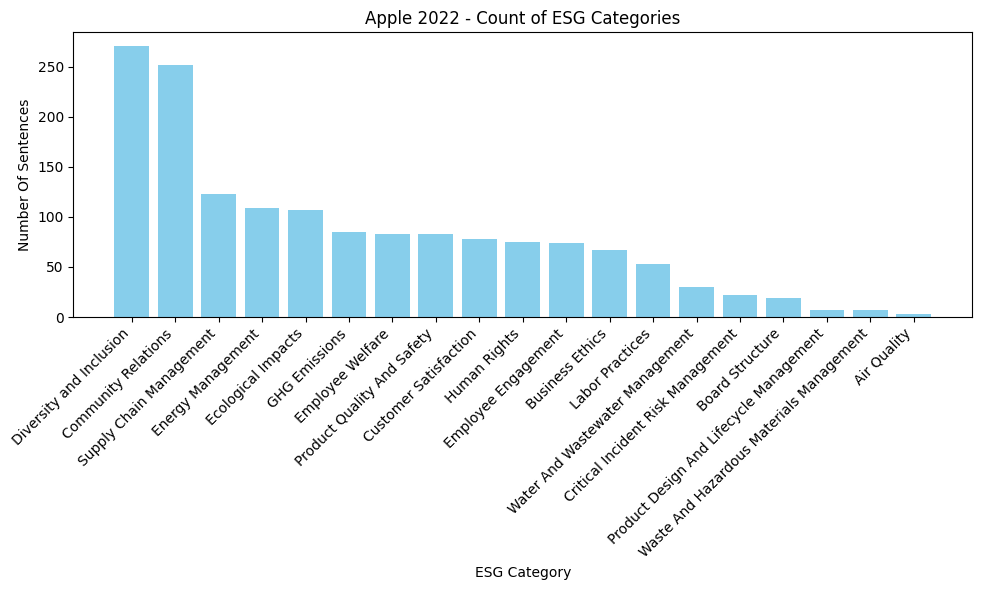

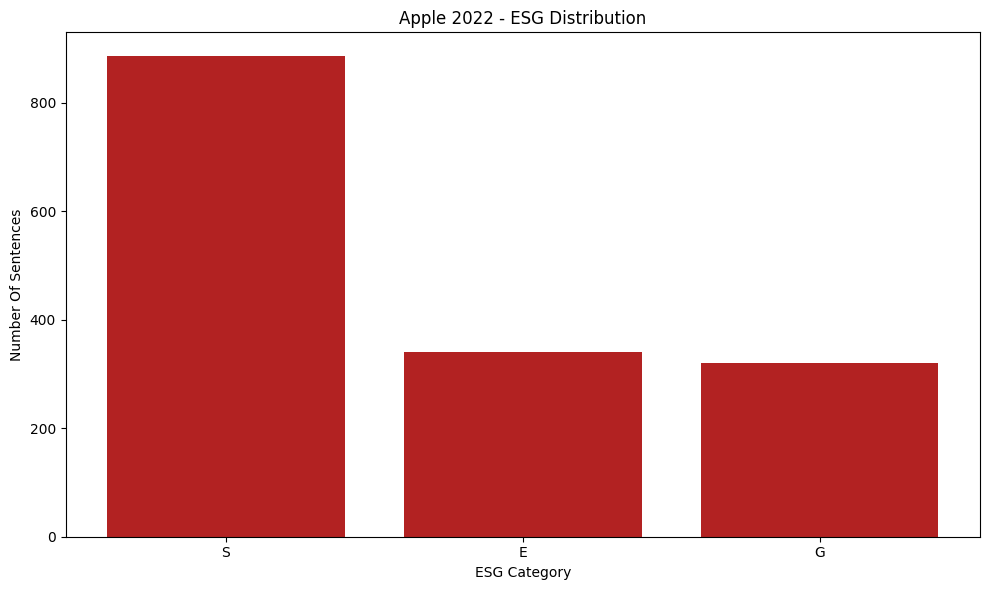

In [ ]:
plot_report(apple_2022_df, apple_name22_label, apple_name22_esg)

***2021***

In [ ]:
apple_2021_df = analyze_report("Apple", "2021", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Apple/Apple_2021.pdf")

In [ ]:
apple_2021_df['statements'] = apple_2021_df['statements'].apply(remove_illegal_chars)
apple_2021_df.to_excel('apple_2021.xlsx')
files.download('apple_2021.xlsx')
apple_2021_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2021.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name21_label = "Apple 2021 - Count of ESG Categories"
apple_name21_esg = "Apple 2021 - ESG Distribution"

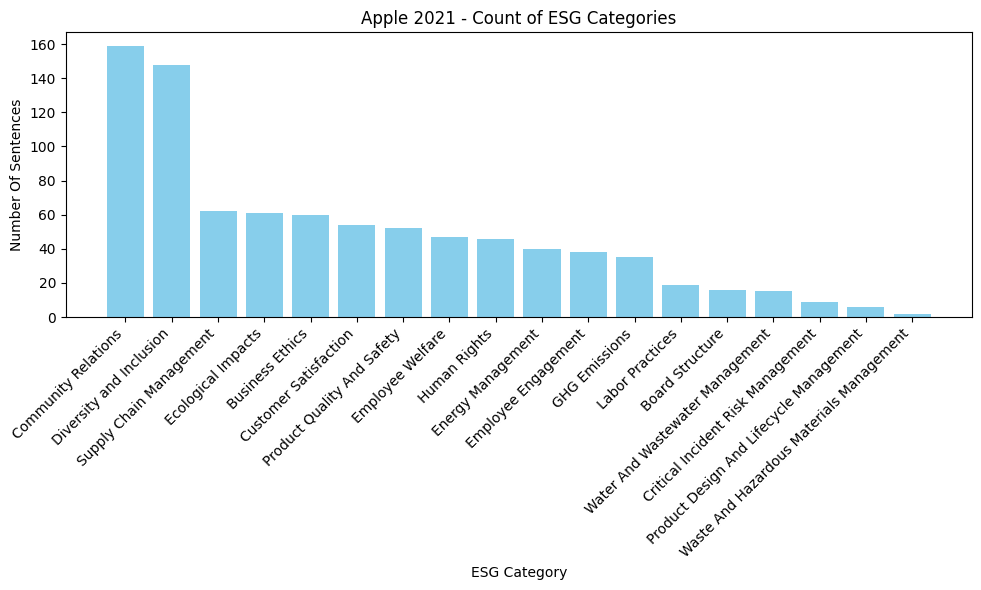

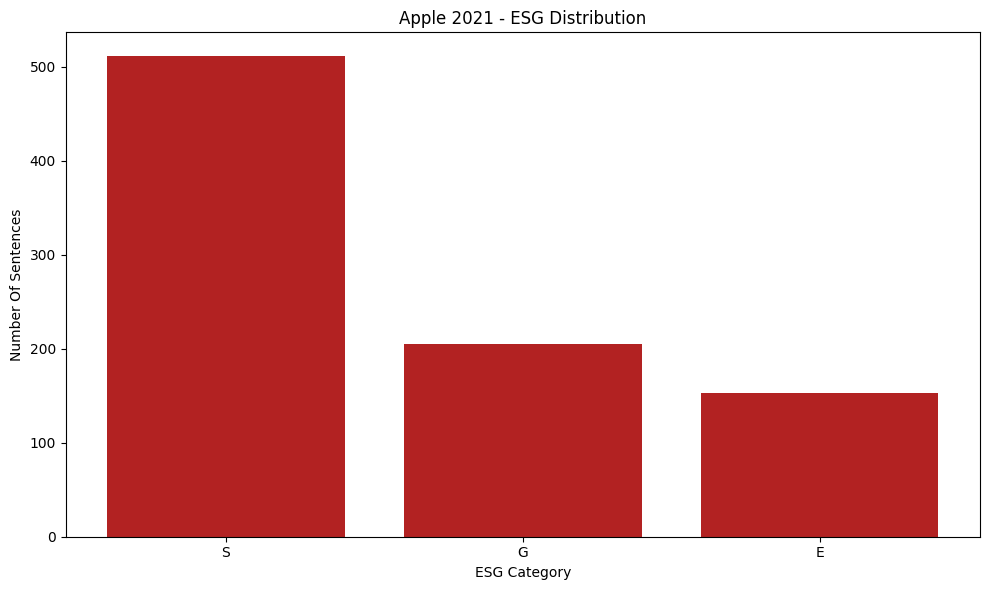

In [ ]:
plot_report(apple_2021_df, apple_name21_label, apple_name21_esg)

***2020***

In [ ]:
apple_2020_df = analyze_report("Apple", "2020", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Apple/Apple_2020.pdf")

In [ ]:
apple_2020_df['statements'] = apple_2020_df['statements'].apply(remove_illegal_chars)
apple_2020_df.to_excel('apple_2020.xlsx')
files.download('apple_2020.xlsx')
apple_2020_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2020.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name20_label = "Apple 2020 - Count of ESG Categories"
apple_name20_esg = "Apple 2020 - ESG Distribution"

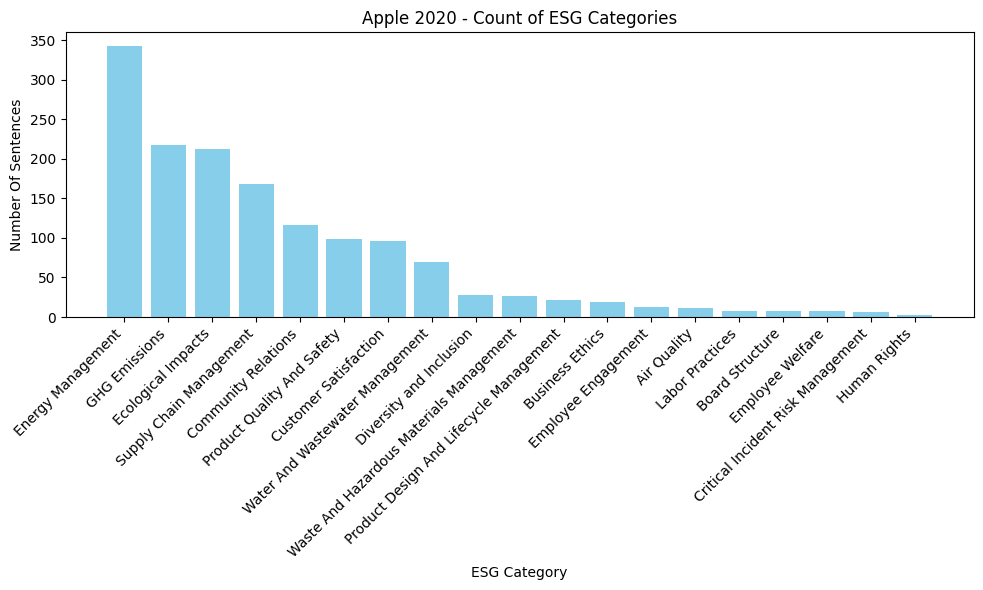

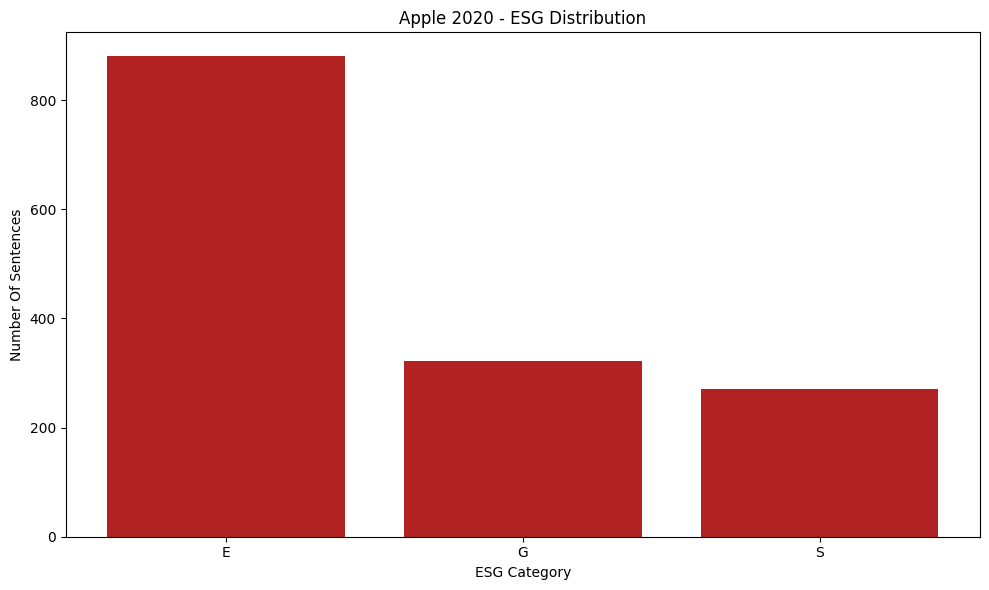

In [ ]:
plot_report(apple_2020_df, apple_name20_label, apple_name20_esg)

***2019***

In [ ]:
apple_2019_df = analyze_report("Apple", "2019", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Apple/Apple_2019.pdf")

In [ ]:
apple_2019_df['statements'] = apple_2019_df['statements'].apply(remove_illegal_chars)
apple_2019_df.to_excel('apple_2019.xlsx')
files.download('apple_2019.xlsx')
apple_2019_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2019.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name19_label = "Apple 2019 - Count of ESG Categories"
apple_name19_esg = "Apple 2019 - ESG Distribution"

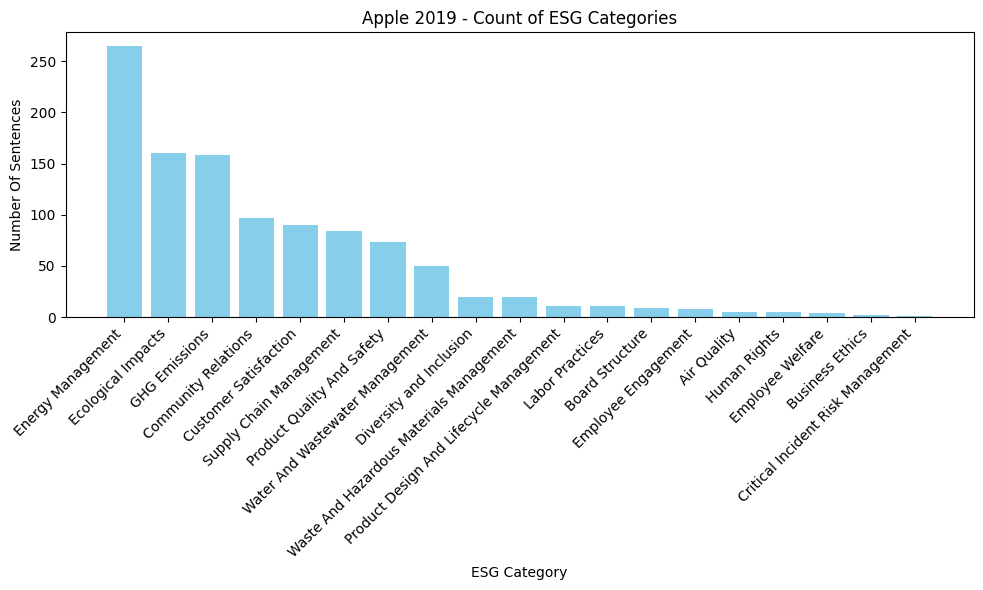

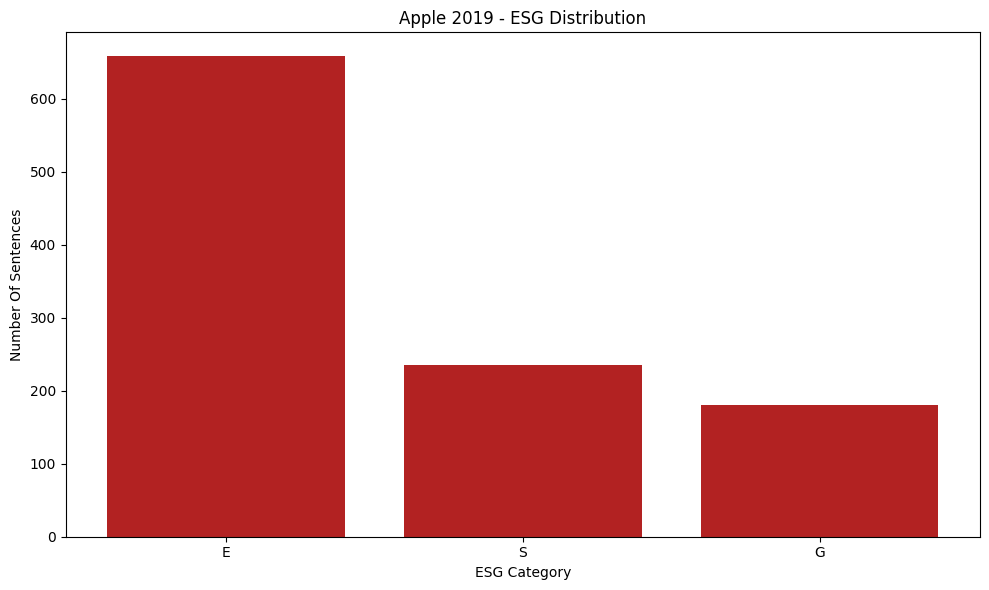

In [ ]:
plot_report(apple_2019_df, apple_name19_label, apple_name19_esg)

***2018***

In [ ]:
apple_2018_df = analyze_report("Apple", "2018", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Apple/Apple_2018.pdf")

In [ ]:
apple_2018_df['statements'] = apple_2018_df['statements'].apply(remove_illegal_chars)
apple_2018_df.to_excel('apple_2018.xlsx')
files.download('apple_2018.xlsx')
apple_2018_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2018.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name18_label = "Apple 2018 - Count of ESG Categories"
apple_name18_esg = "Apple 2018 - ESG Distribution"

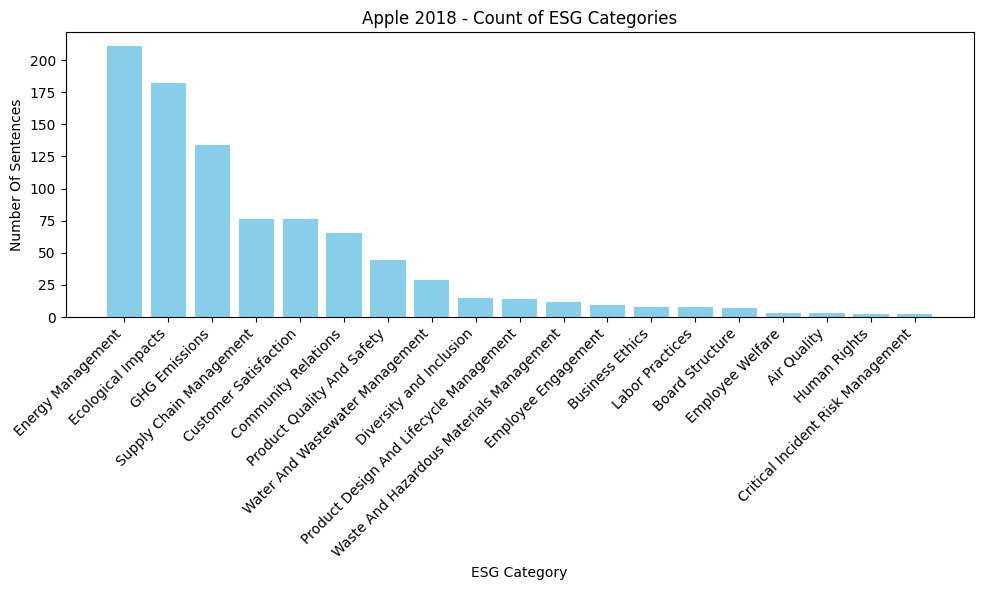

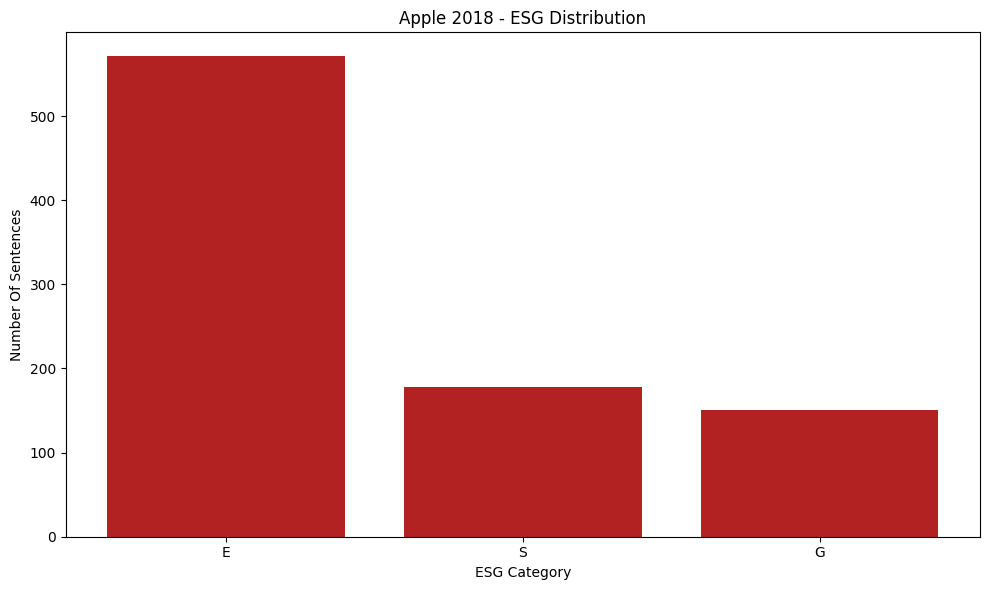

In [ ]:
plot_report(apple_2018_df, apple_name18_label, apple_name18_esg)

***Comparison***

In [ ]:
apple_2022_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2022.xlsx")
apple_2021_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2021.xlsx")
apple_2020_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2020.xlsx")
apple_2019_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2019.xlsx")
apple_2018_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Apple/apple_2018.xlsx")

In [ ]:
apple_2022_df_id = count_id(apple_2022_df)
apple_2021_df_id = count_id(apple_2021_df)
apple_2020_df_id = count_id(apple_2020_df)
apple_2019_df_id = count_id(apple_2019_df)
apple_2018_df_id = count_id(apple_2018_df)

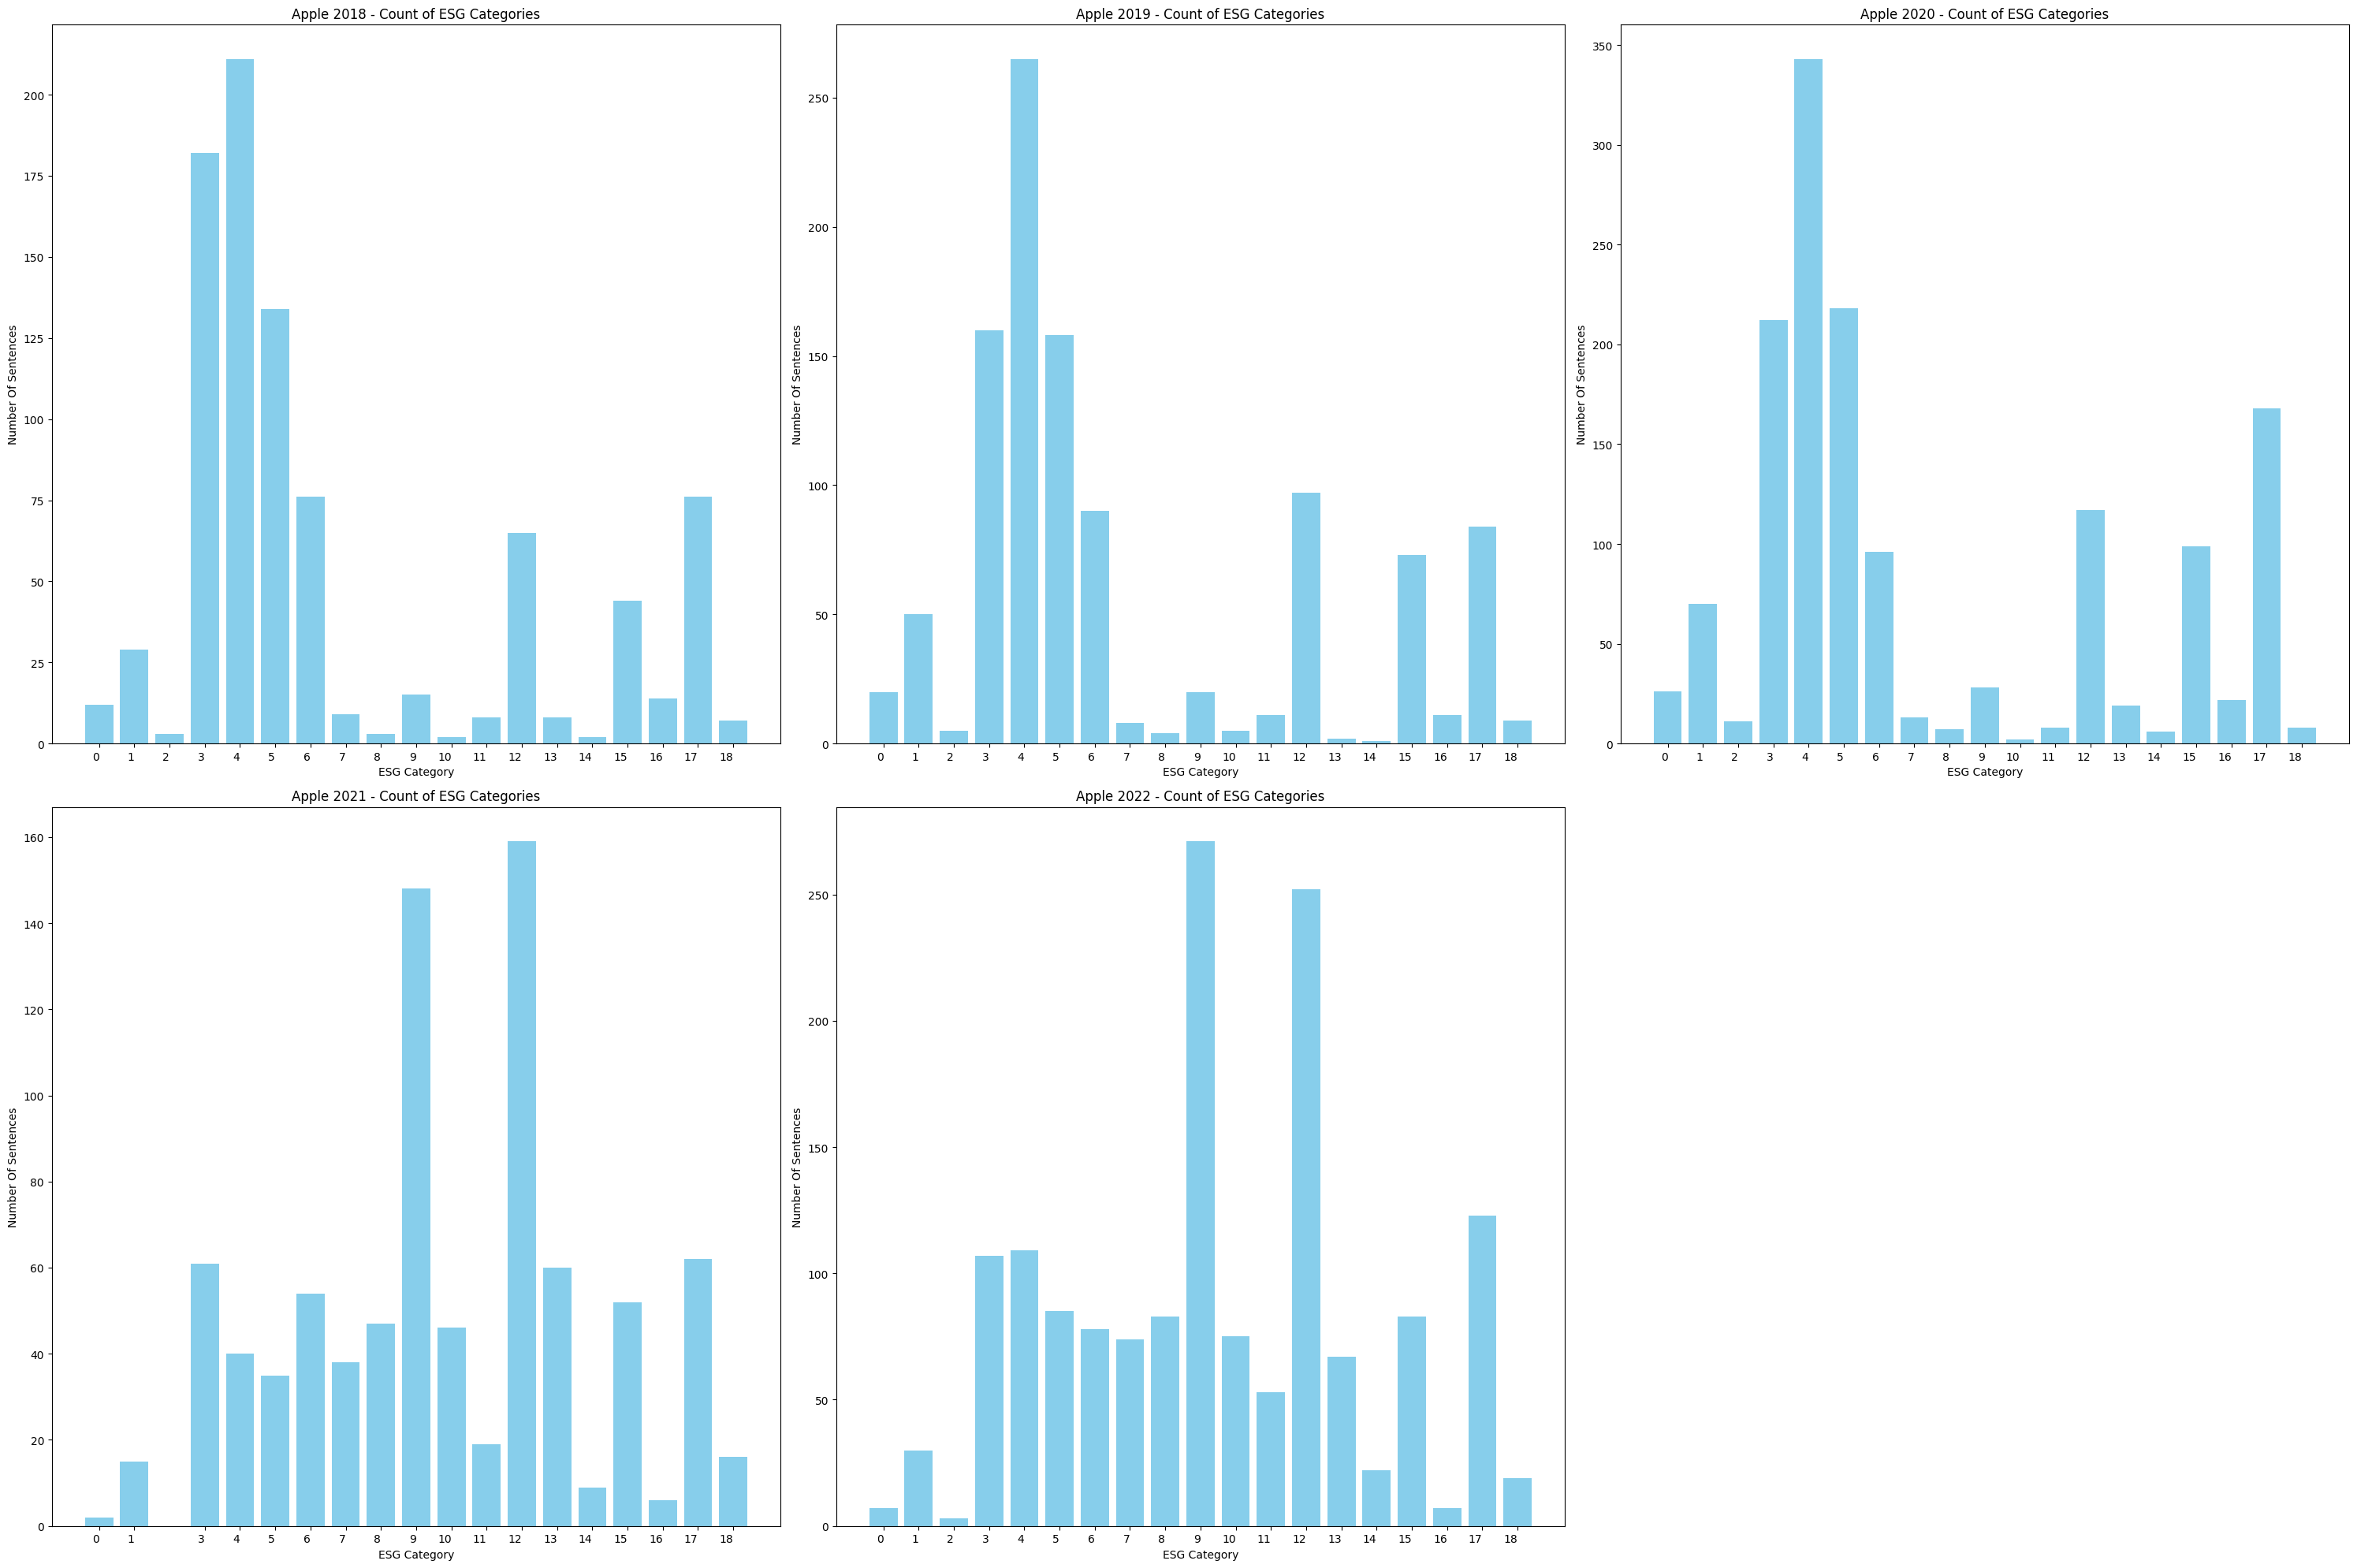

In [ ]:
plot_all(apple_2022_df_id, apple_name22_label, apple_2021_df_id, apple_name21_label, apple_2020_df_id, apple_name20_label, apple_2019_df_id, apple_name19_label, apple_2018_df_id, apple_name18_label)

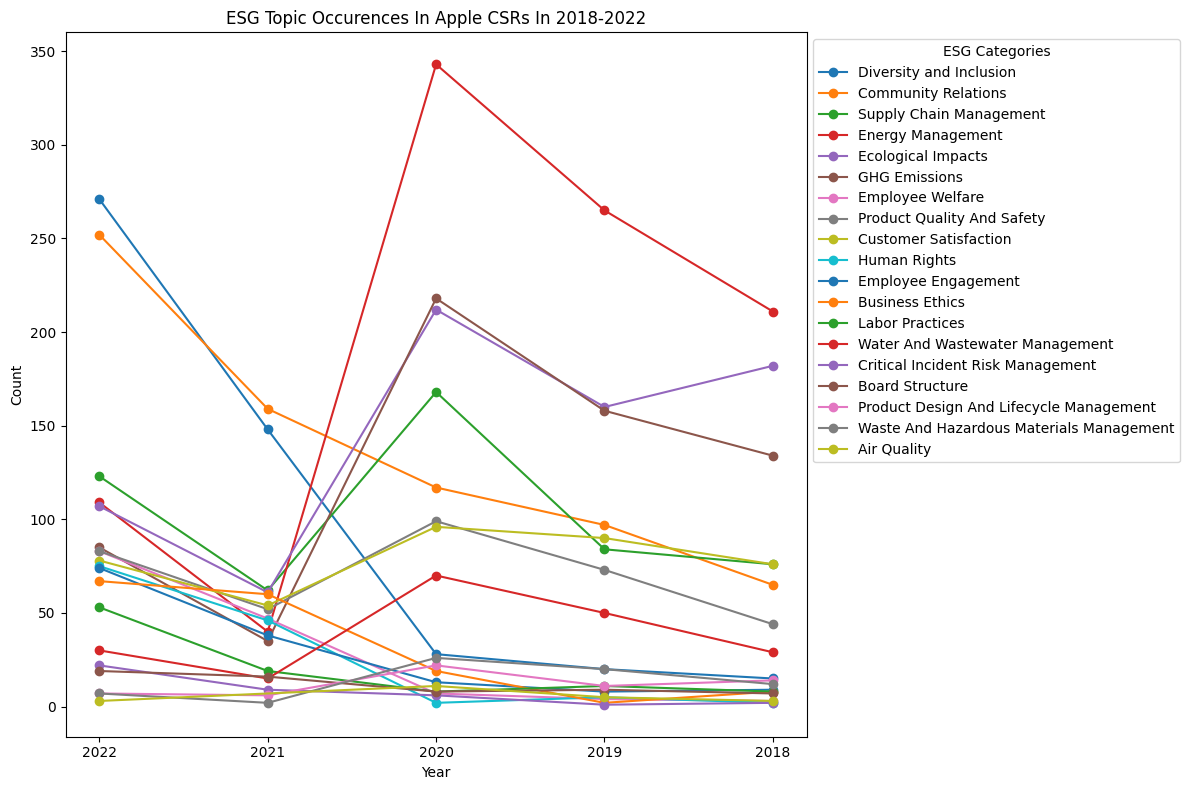

In [ ]:
apple_dfs = [
    apple_2022_df,
    apple_2021_df,
    apple_2020_df,
    apple_2019_df,
    apple_2018_df
]

plot_label_evolution(apple_dfs, "ESG Topic Occurences In Apple CSRs In 2018-2022")





# **Walmart**


---



***2022***

In [ ]:
walmart_2022_df = analyze_report("Walmart", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Walmart/Walmart_2022.pdf")

In [ ]:
walmart_2022_df['statements'] = walmart_2022_df['statements'].apply(remove_illegal_chars)
walmart_2022_df.to_excel('walmart_2022.xlsx')
files.download('walmart_2022.xlsx')
walmart_2022_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2022.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name22_label = "Walmart 2022 - Count of ESG Categories"
walmart_name22_esg = "Walmart 2022 - ESG Distribution"

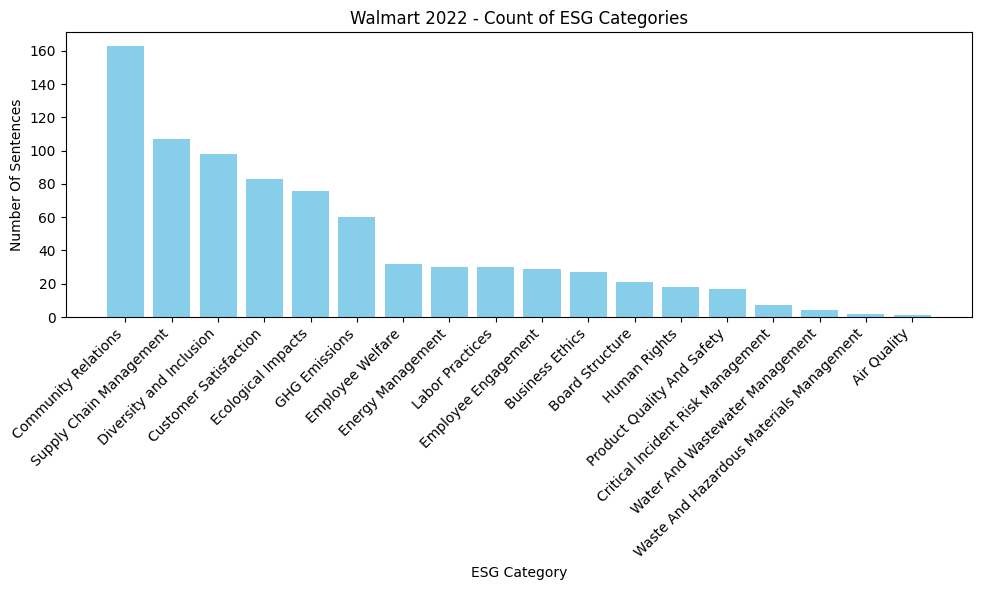

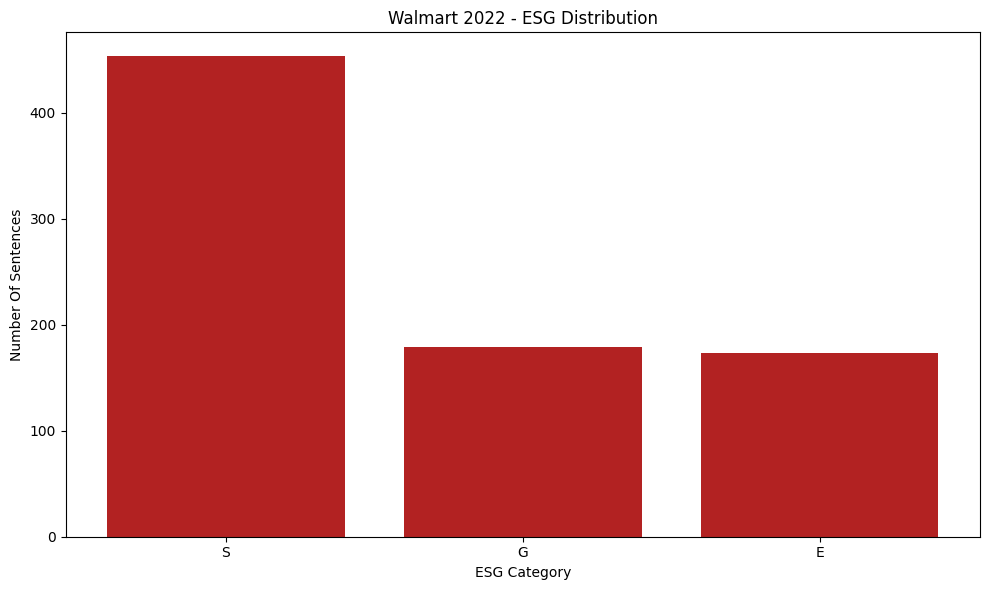

In [ ]:
plot_report(walmart_2022_df, walmart_name22_label, walmart_name22_esg)

***2021***

In [ ]:
walmart_2021_df = analyze_report("Walmart", "2021", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Walmart/Walmart_2021.pdf")

In [ ]:
walmart_2021_df['statements'] = walmart_2021_df['statements'].apply(remove_illegal_chars)
walmart_2021_df.to_excel('walmart_2021.xlsx')
files.download('walmart_2021.xlsx')
walmart_2021_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2021.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name21_label = "Walmart 2021 - Count of ESG Categories"
walmart_name21_esg = "Walmart 2021 - ESG Distribution"

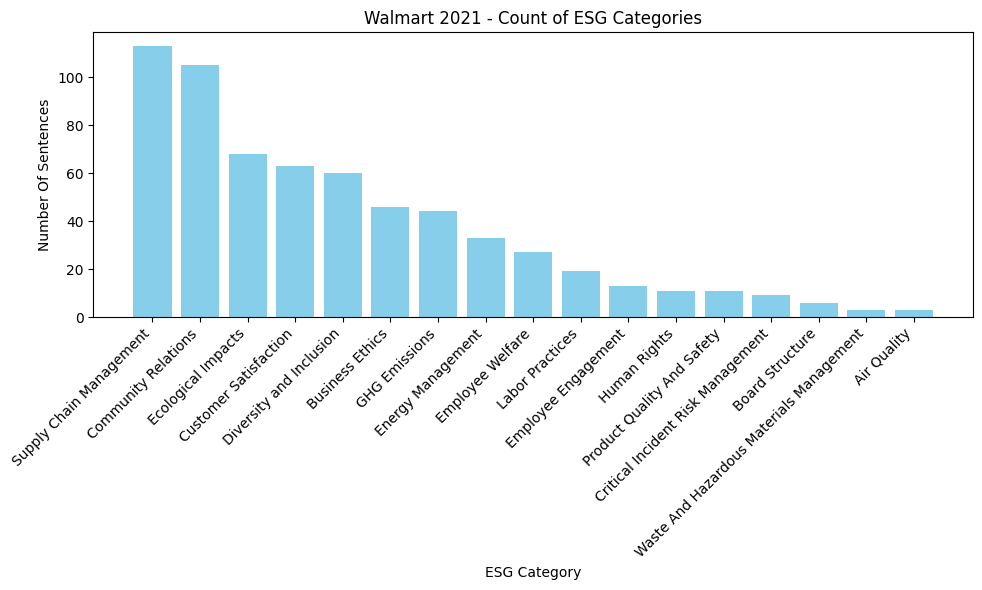

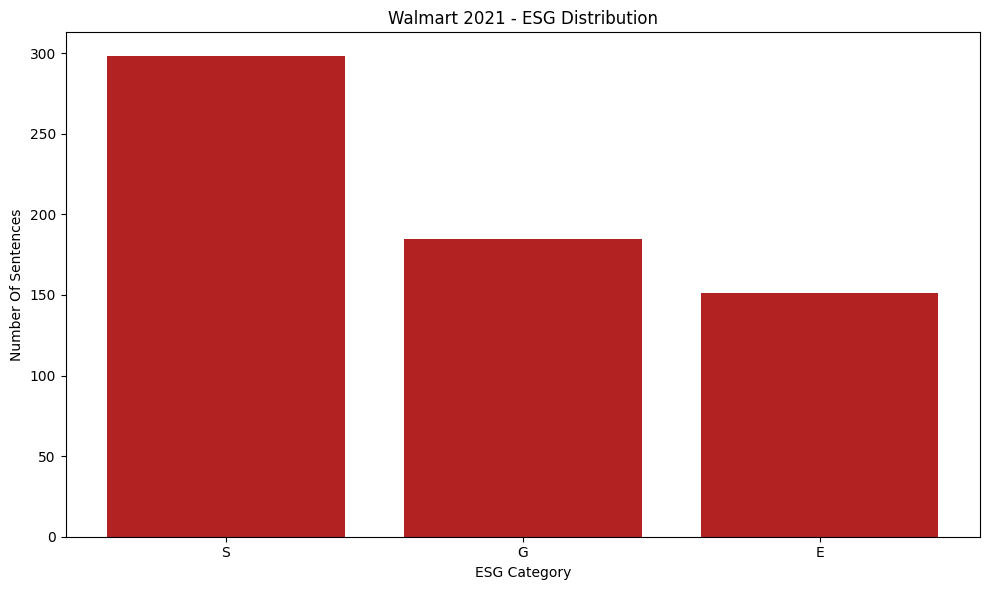

In [ ]:
plot_report(walmart_2021_df, walmart_name21_label, walmart_name21_esg)

***2020***

In [ ]:
walmart_2020_df = analyze_report("Walmart", "2020", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Walmart/Walmart_2020.pdf")

In [ ]:
walmart_2020_df['statements'] = walmart_2020_df['statements'].apply(remove_illegal_chars)
walmart_2020_df.to_excel('walmart_2020.xlsx')
files.download('walmart_2020.xlsx')
walmart_2020_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2020.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name20_label = "Walmart 2020 - Count of ESG Categories"
walmart_name20_esg = "Walmart 2020 - ESG Distribution"

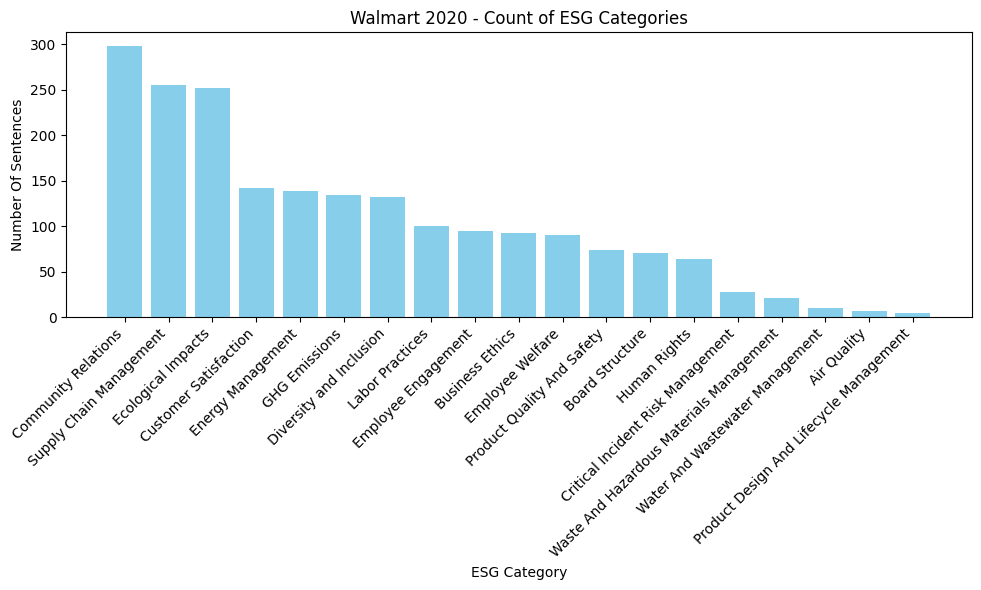

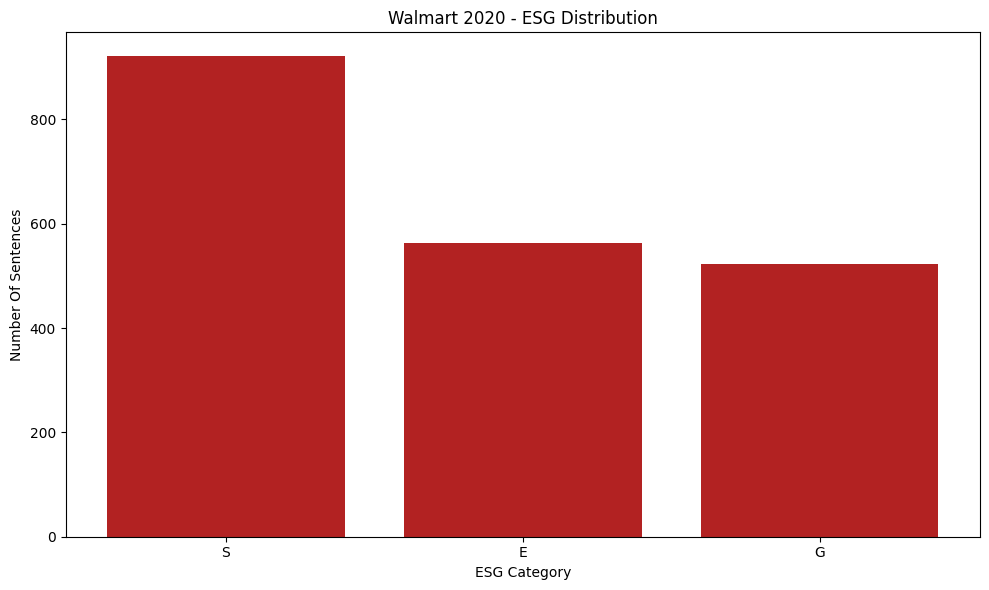

In [ ]:
plot_report(walmart_2020_df, walmart_name20_label, walmart_name20_esg)

***2019***

In [ ]:
walmart_2019_df = analyze_report("Walmart", "2019", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Walmart/Walmart_2019.pdf")

In [ ]:
walmart_2019_df['statements'] = walmart_2019_df['statements'].apply(remove_illegal_chars)
walmart_2019_df.to_excel('walmart_2019.xlsx')
files.download('walmart_2019.xlsx')
walmart_2019_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2019.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name19_label = "Walmart 2019 - Count of ESG Categories"
walmart_name19_esg = "Walmart 2019 - ESG Distribution"

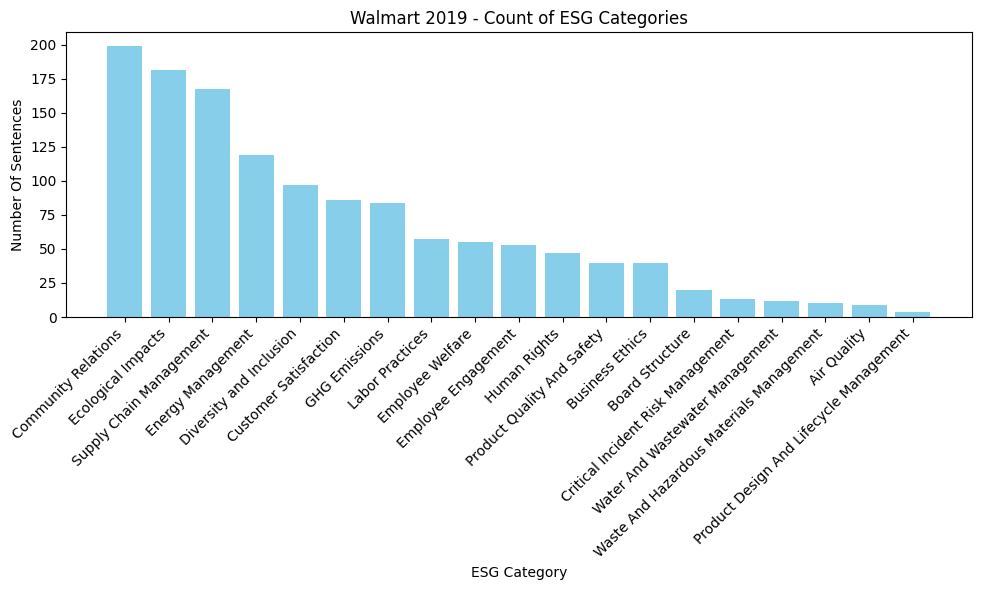

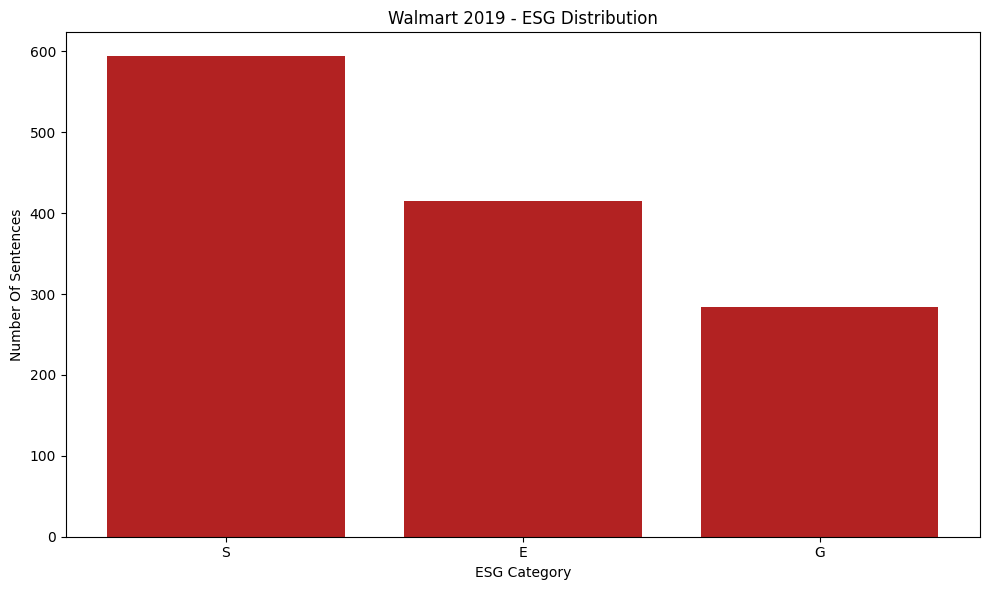

In [ ]:
plot_report(walmart_2019_df, walmart_name19_label, walmart_name19_esg)

***2018***

In [ ]:
walmart_2018_df = analyze_report("Walmart", "2018", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Walmart/Walmart_2018.pdf")

In [ ]:
walmart_2018_df['statements'] = walmart_2018_df['statements'].apply(remove_illegal_chars)
walmart_2018_df.to_excel('walmart_2018.xlsx')
files.download('walmart_2018.xlsx')
walmart_2018_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2018.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name18_label = "Walmart 2018 - Count of ESG Categories"
walmart_name18_esg = "Walmart 2018 - ESG Distribution"

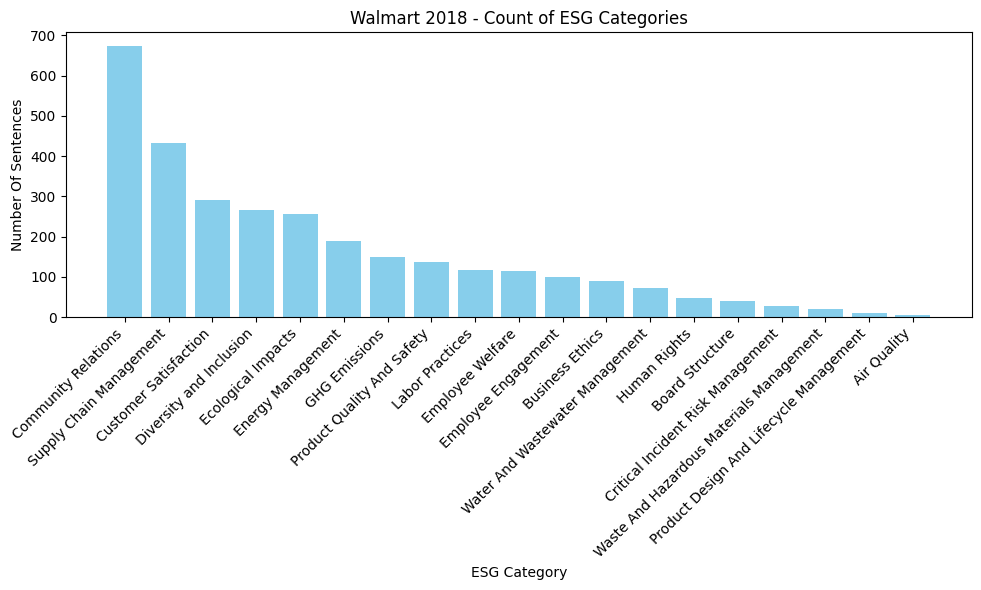

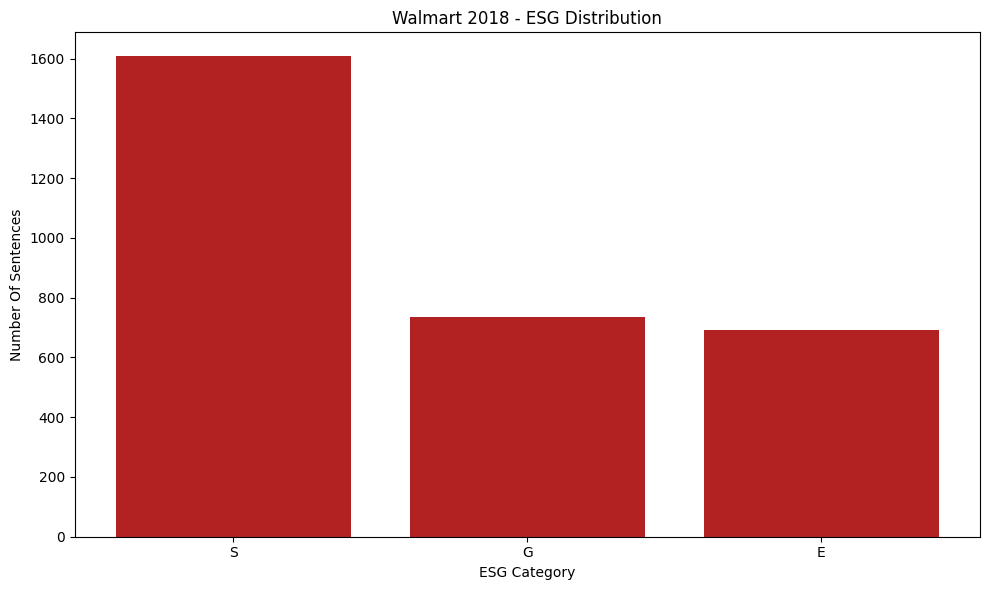

In [ ]:
plot_report(walmart_2018_df, walmart_name18_label, walmart_name18_esg)

***Comparison***

In [ ]:
walmart_2022_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2022.xlsx")
walmart_2021_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2021.xlsx")
walmart_2020_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2020.xlsx")
walmart_2019_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2019.xlsx")
walmart_2018_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Walmart/walmart_2018.xlsx")

In [ ]:
walmart_2022_df_id = count_id(walmart_2022_df)
walmart_2021_df_id = count_id(walmart_2021_df)
walmart_2020_df_id = count_id(walmart_2020_df)
walmart_2019_df_id = count_id(walmart_2019_df)
walmart_2018_df_id = count_id(walmart_2018_df)

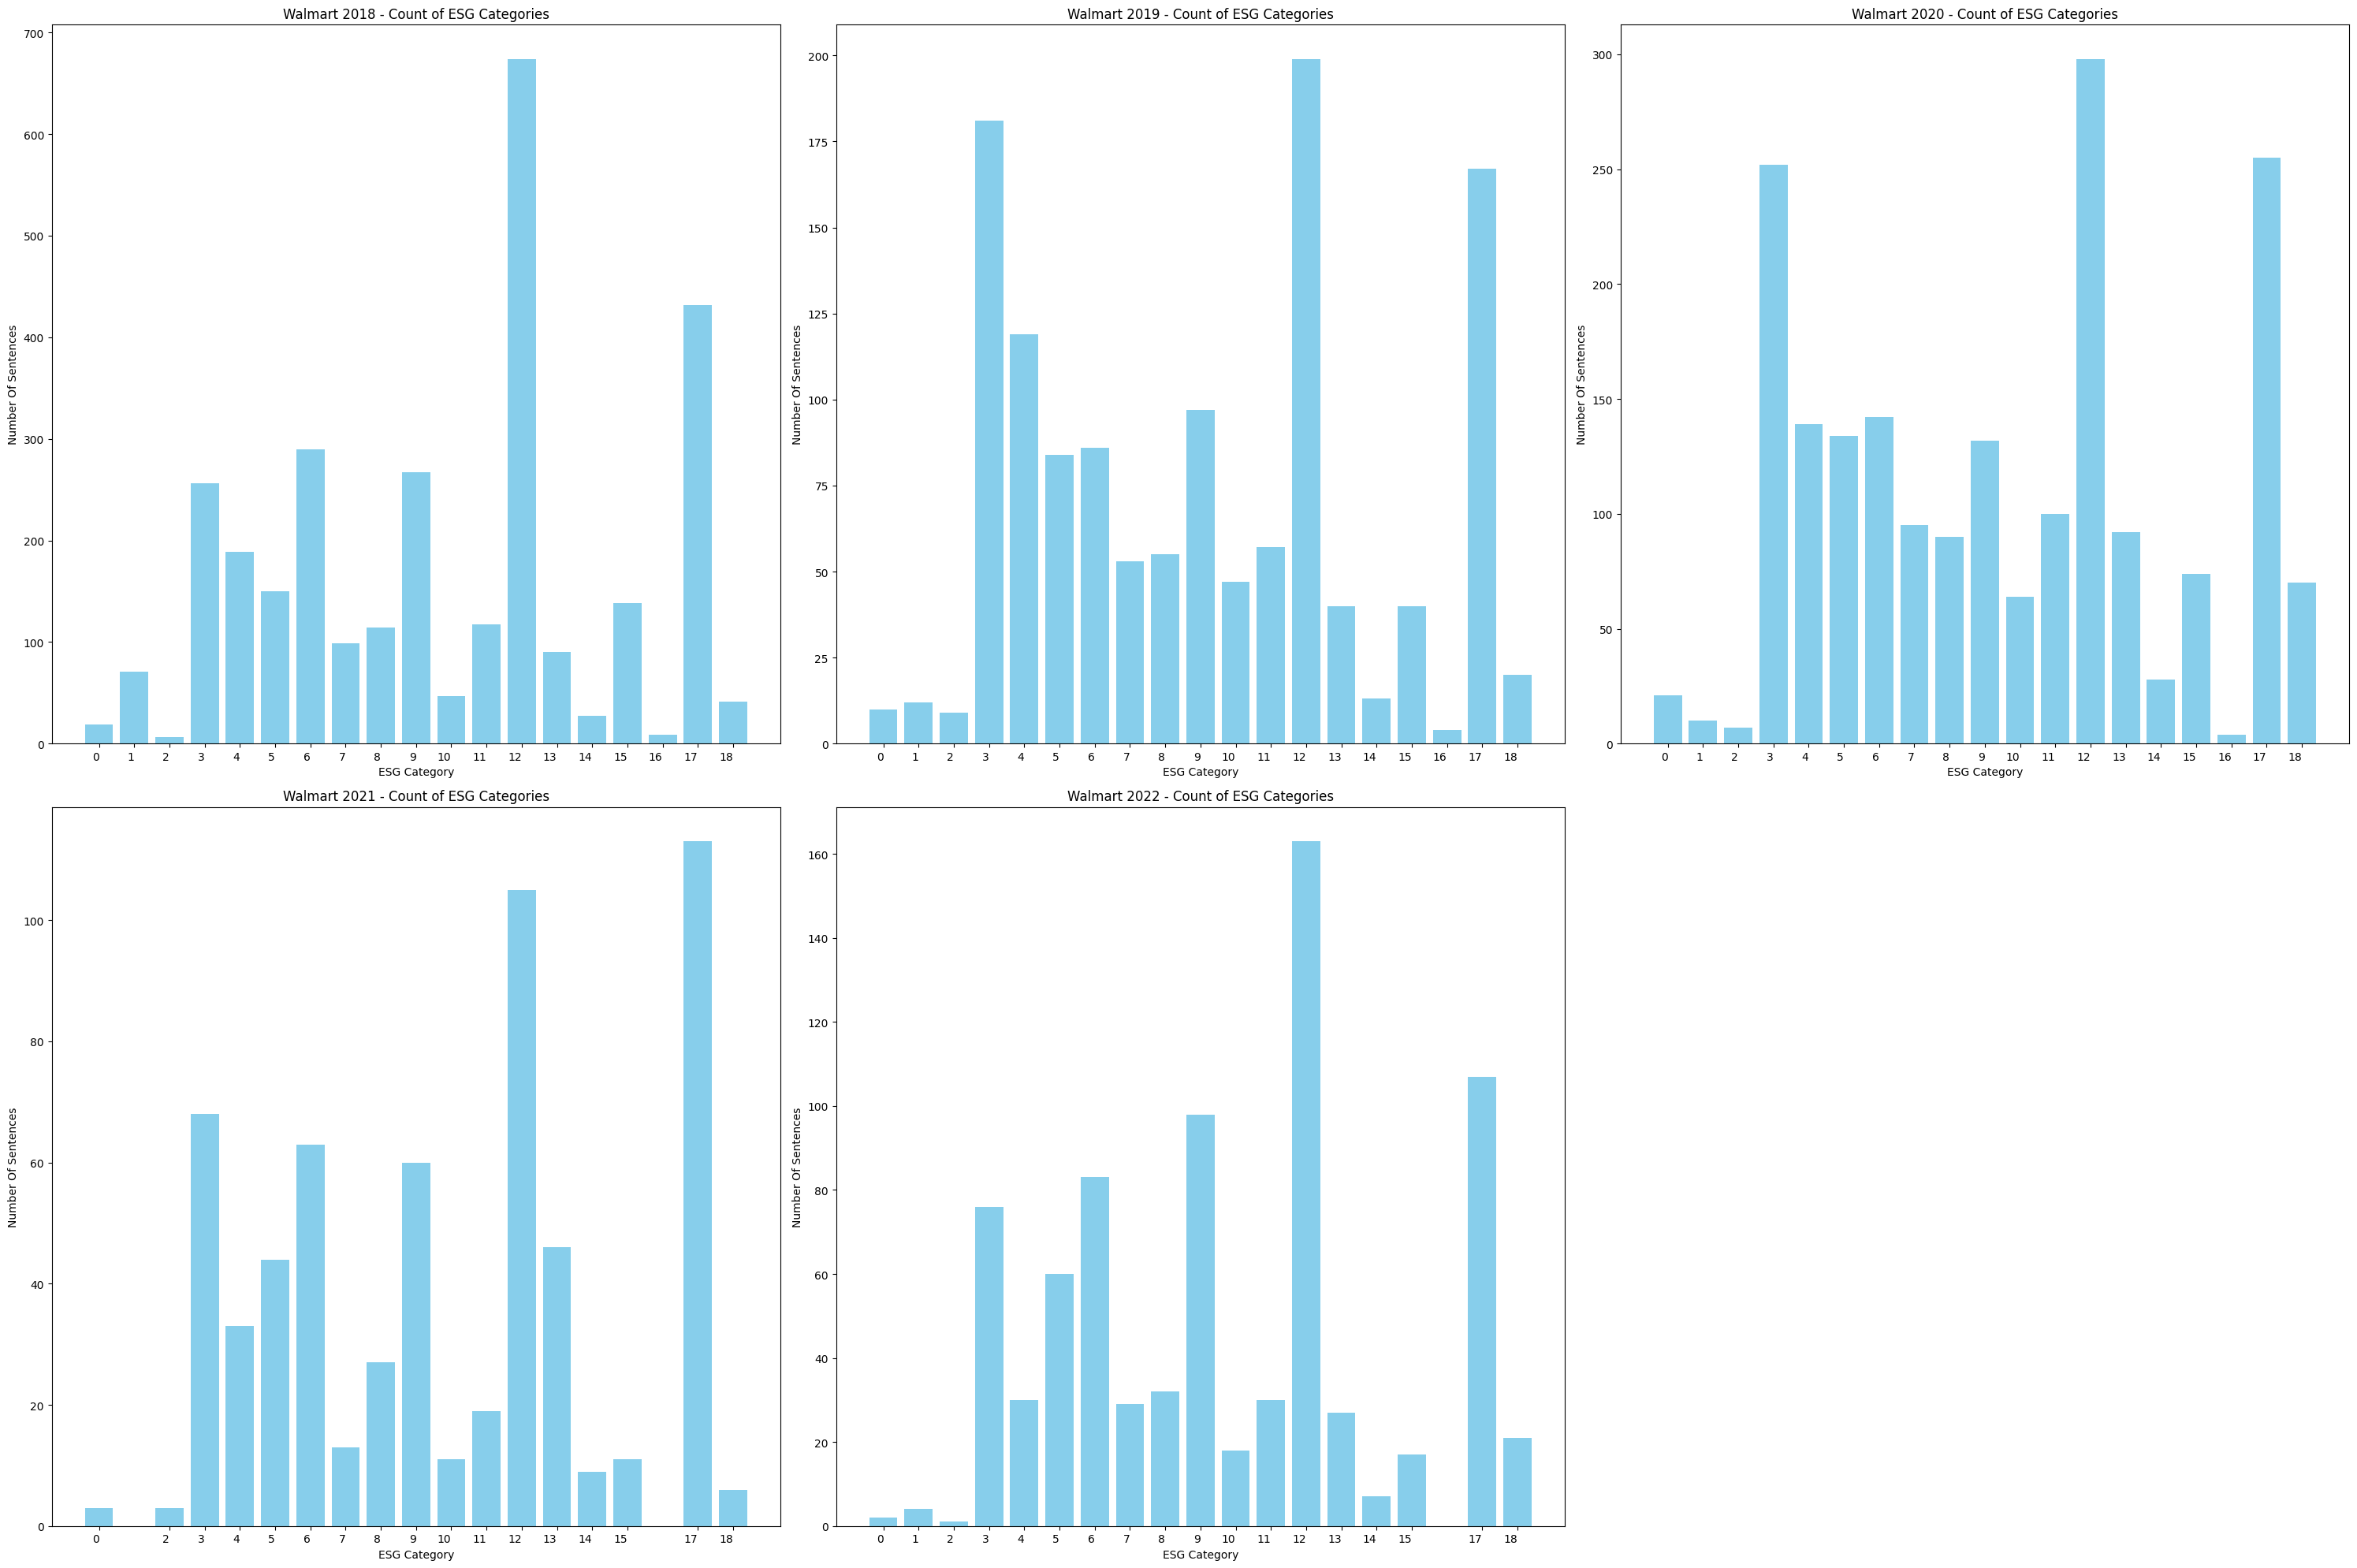

In [ ]:
plot_all(walmart_2022_df_id, walmart_name22_label, walmart_2021_df_id, walmart_name21_label, walmart_2020_df_id, walmart_name20_label, walmart_2019_df_id, walmart_name19_label, walmart_2018_df_id, walmart_name18_label)

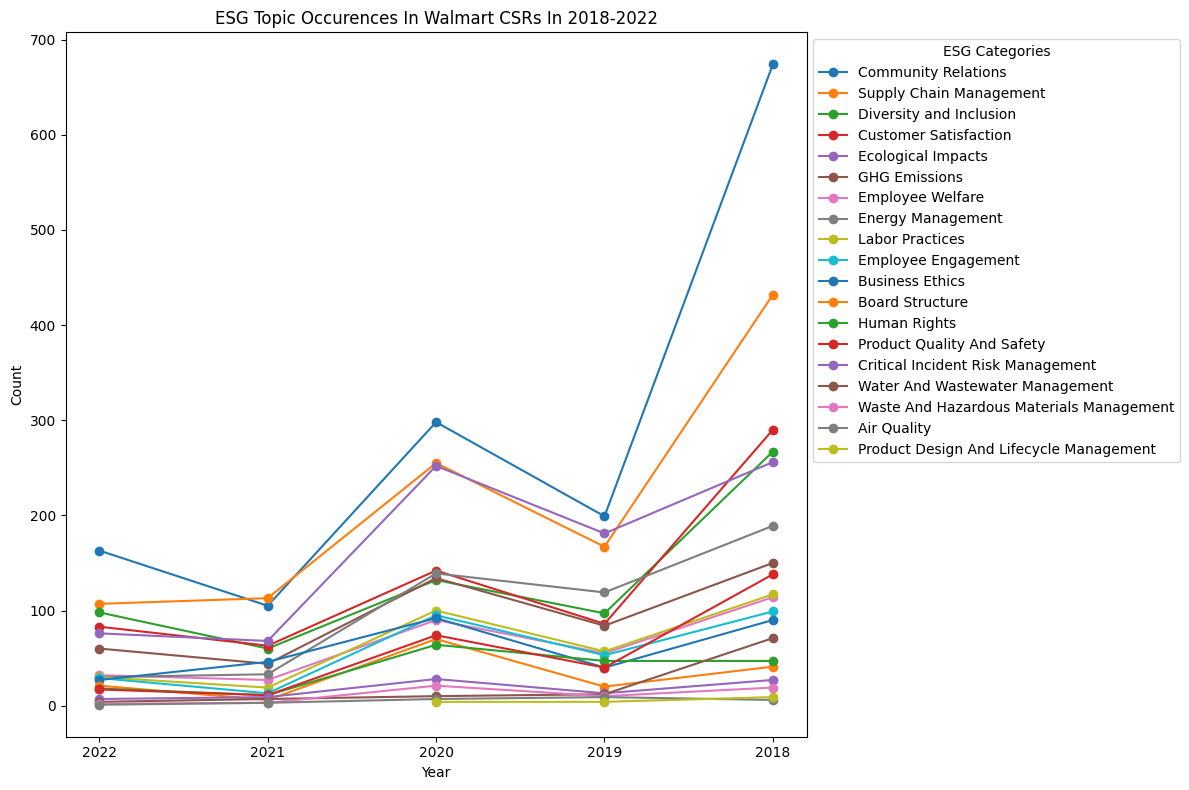

In [ ]:
walmart_dfs = [
    walmart_2022_df,
    walmart_2021_df,
    walmart_2020_df,
    walmart_2019_df,
    walmart_2018_df
]

plot_label_evolution(walmart_dfs, "ESG Topic Occurences In Walmart CSRs In 2018-2022")





# **Chevron**


---



 ***2022***

In [ ]:
chevron_2022_df = analyze_report("Chevron", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Chevron/Chevron_2022.pdf")

In [ ]:
chevron_2022_df['statements'] = chevron_2022_df['statements'].apply(remove_illegal_chars)
chevron_2022_df.to_excel('chevron_2022.xlsx')
files.download('chevron_2022.xlsx')
chevron_2022_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2022.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name22_label = "Chevron 2022 - Count of ESG Categories"
chevron_name22_esg = "Chevron 2022 - ESG Distribution"

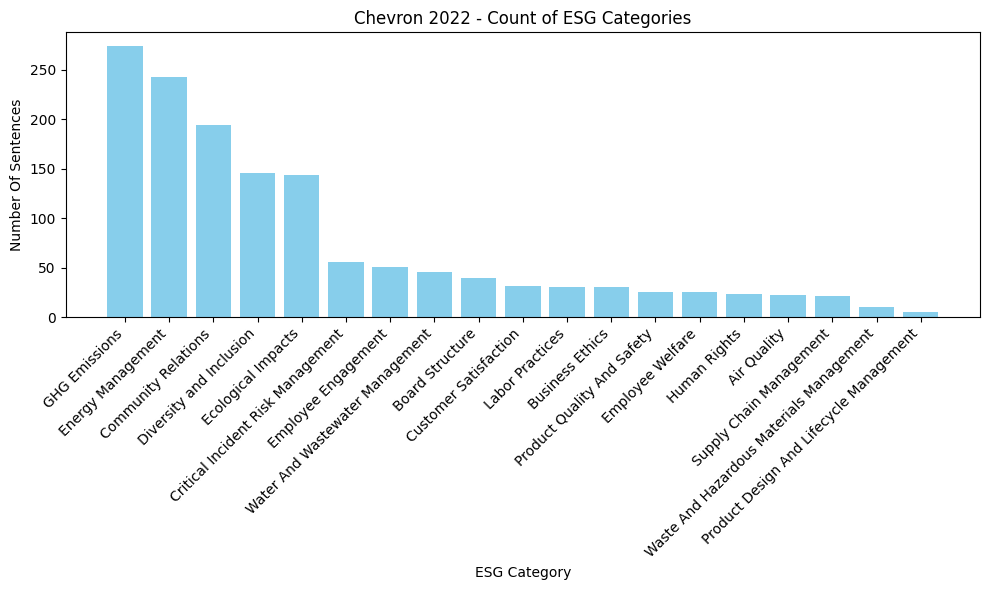

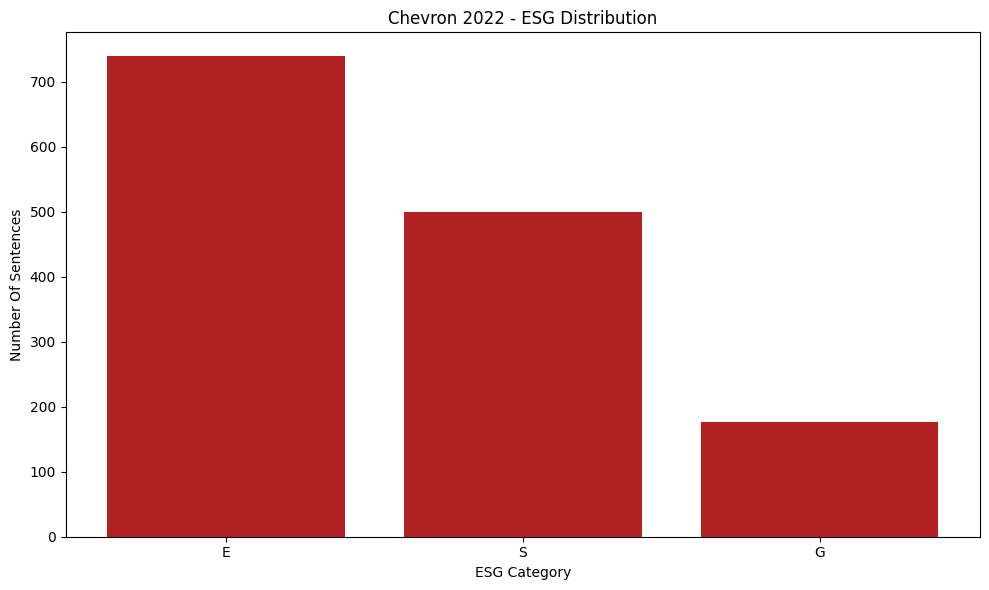

In [ ]:
plot_report(chevron_2022_df, chevron_name22_label, chevron_name22_esg)

***2021***

In [ ]:
chevron_2021_df = analyze_report("Chevron", "2021", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Chevron/Chevron_2021.pdf")

In [ ]:
chevron_2021_df['statements'] = chevron_2021_df['statements'].apply(remove_illegal_chars)
chevron_2021_df.to_excel('chevron_2021.xlsx')
files.download('chevron_2021.xlsx')
chevron_2021_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2021.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name21_label = "Chevron 2021 - Count of ESG Categories"
chevron_name21_esg = "Chevron 2021 - ESG Distribution"

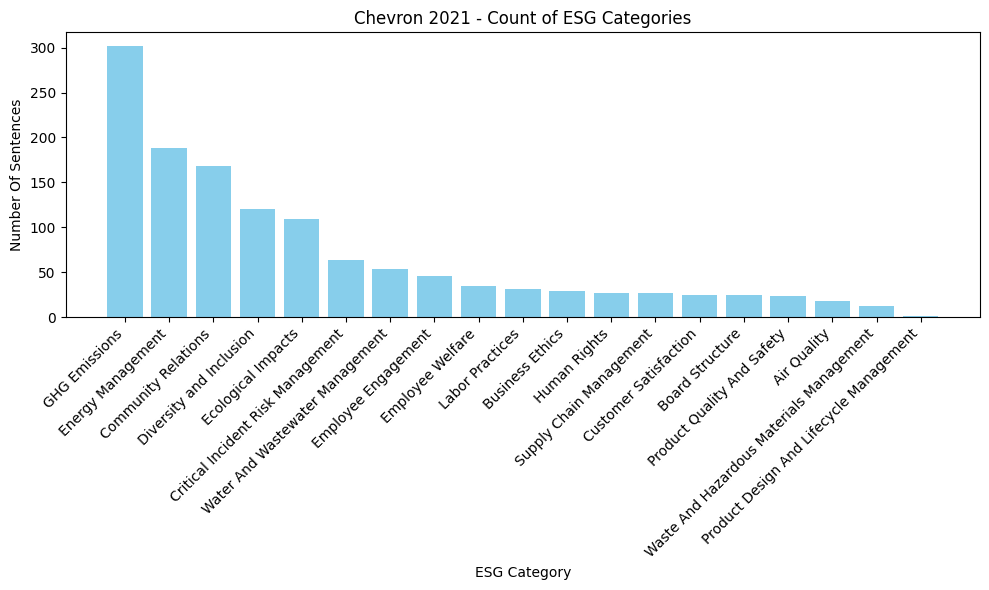

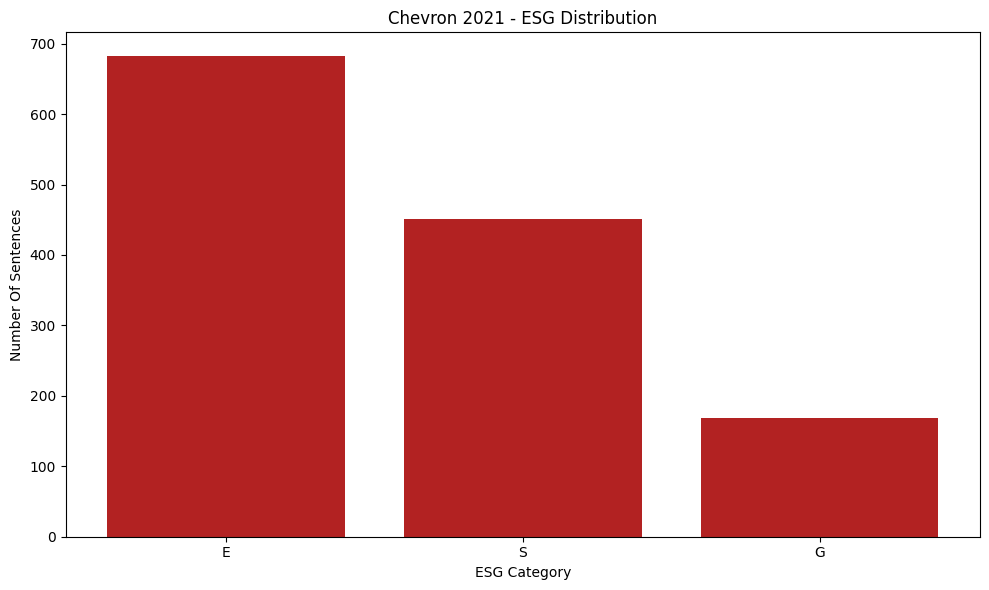

In [ ]:
plot_report(chevron_2021_df, chevron_name21_label, chevron_name21_esg)

***2020***

In [ ]:
chevron_2020_df = analyze_report("Chevron", "2020", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Chevron/Chevron_2020.pdf")

In [ ]:
chevron_2020_df['statements'] = chevron_2020_df['statements'].apply(remove_illegal_chars)
chevron_2020_df.to_excel('chevron_2020.xlsx')
files.download('chevron_2020.xlsx')
chevron_2020_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2020.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name20_label = "Chevron 2020 - Count of ESG Categories"
chevron_name20_esg = "Chevron 2020 - ESG Distribution"

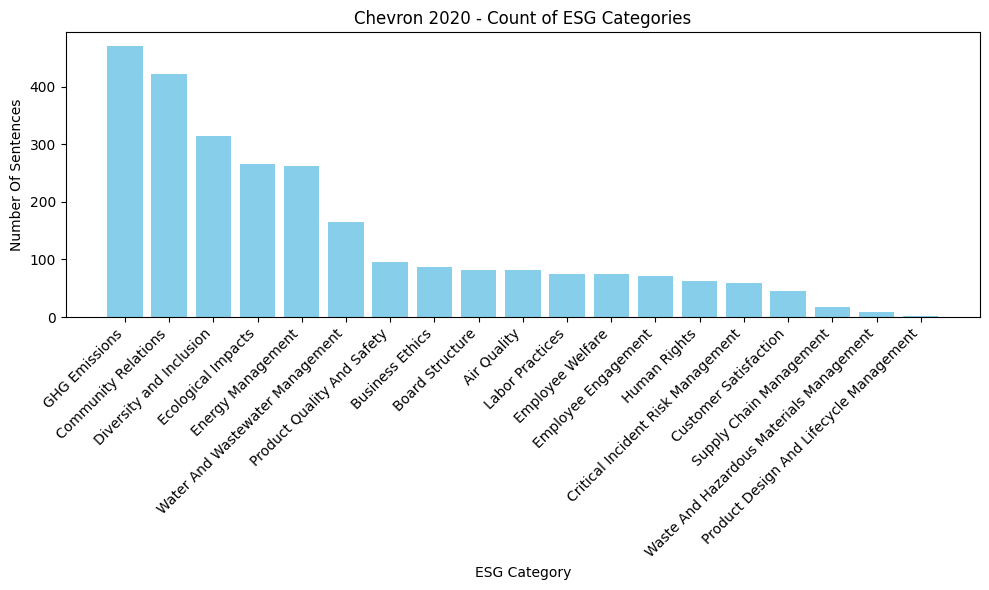

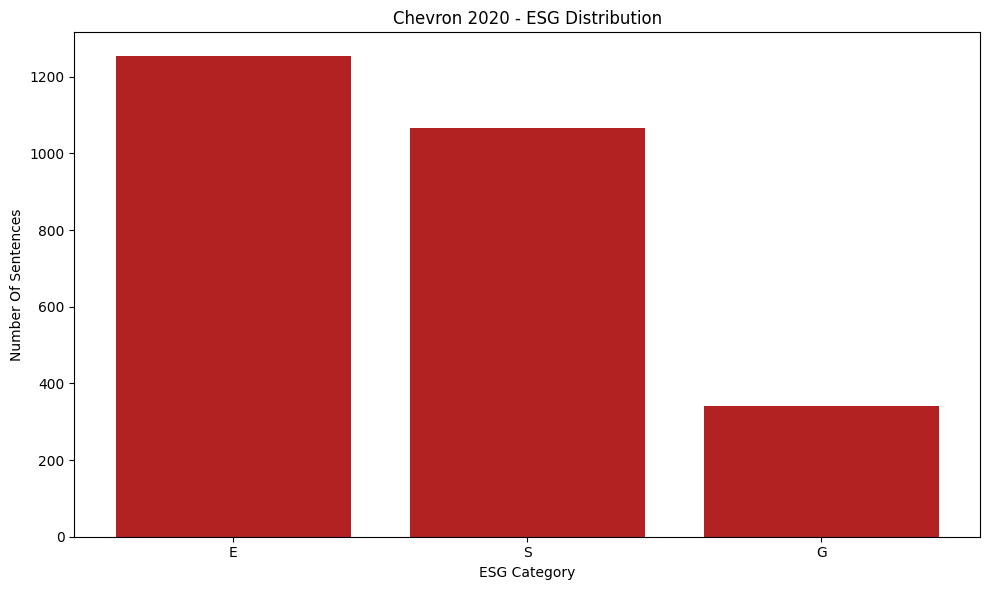

In [ ]:
plot_report(chevron_2020_df, chevron_name20_label, chevron_name20_esg)

***2019***

In [ ]:
chevron_2019_df = analyze_report("Chevron", "2019", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Chevron/Chevron_2019.pdf")

In [ ]:
chevron_2019_df['statements'] = chevron_2019_df['statements'].apply(remove_illegal_chars)
chevron_2019_df.to_excel('chevron_2019.xlsx')
files.download('chevron_2019.xlsx')
chevron_2019_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2019.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name19_label = "Chevron 2019 - Count of ESG Categories"
chevron_name19_esg = "Chevron 2019 - ESG Distribution"

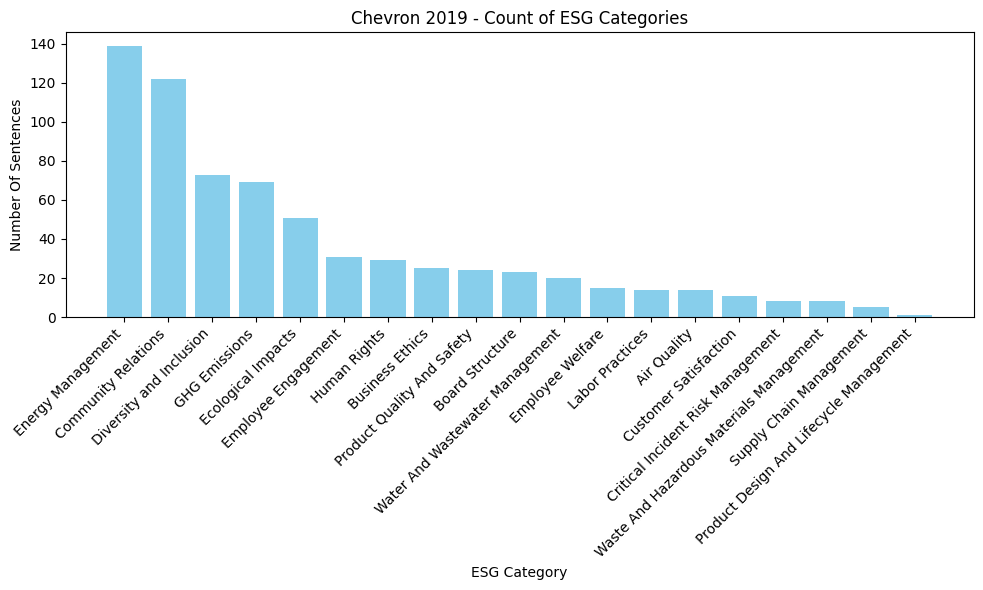

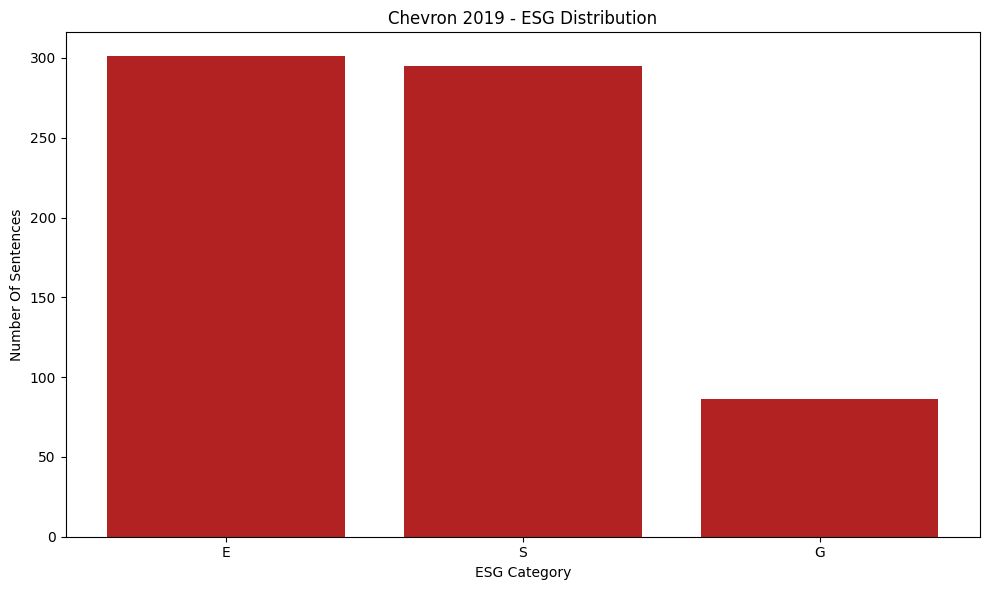

In [ ]:
plot_report(chevron_2019_df, chevron_name19_label, chevron_name19_esg)

***2018***

In [ ]:
chevron_2018_df = analyze_report("Chevron", "2018", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/Chevron/Chevron_2018.pdf")

In [ ]:
chevron_2018_df['statements'] = chevron_2018_df['statements'].apply(remove_illegal_chars)
chevron_2018_df.to_excel('chevron_2018.xlsx')
files.download('chevron_2018.xlsx')
chevron_2018_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2018.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name18_label = "Chevron 2018 - Count of ESG Categories"
chevron_name18_esg = "Chevron 2018 - ESG Distribution"

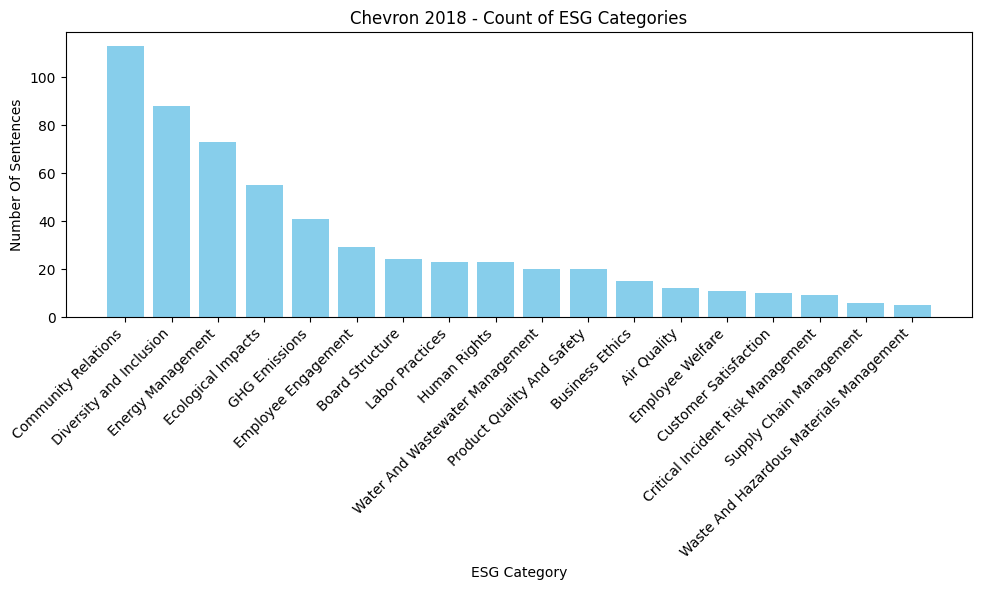

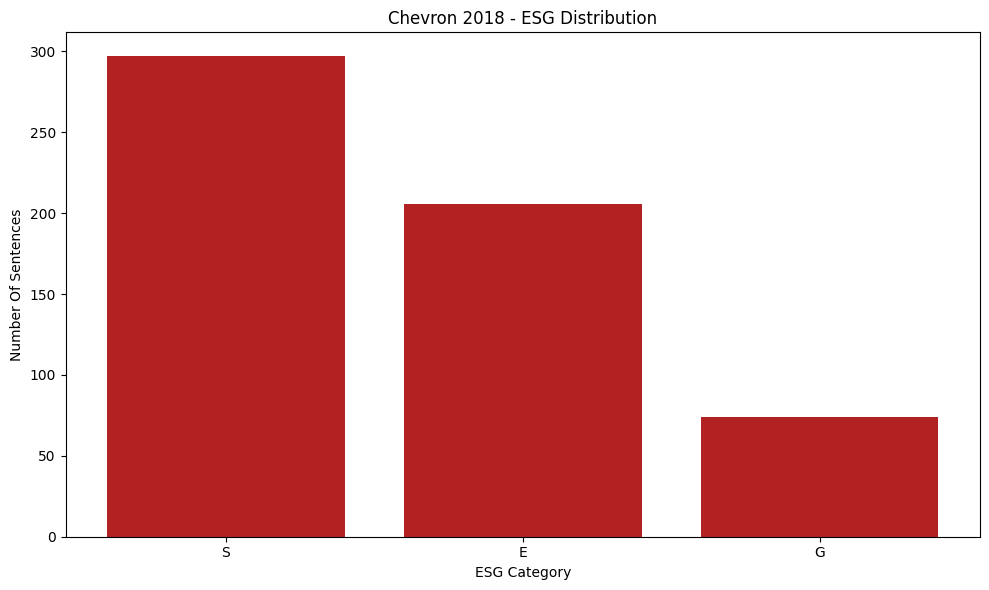

In [ ]:
plot_report(chevron_2018_df, chevron_name18_label, chevron_name18_esg)

***Comparison***

In [ ]:
chevron_2022_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2022.xlsx")
chevron_2021_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2021.xlsx")
chevron_2020_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2020.xlsx")
chevron_2019_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2019.xlsx")
chevron_2018_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/Chevron/chevron_2018.xlsx")

In [ ]:
chevron_2022_df_id = count_id(chevron_2022_df)
chevron_2021_df_id = count_id(chevron_2021_df)
chevron_2020_df_id = count_id(chevron_2020_df)
chevron_2019_df_id = count_id(chevron_2019_df)
chevron_2018_df_id = count_id(chevron_2018_df)

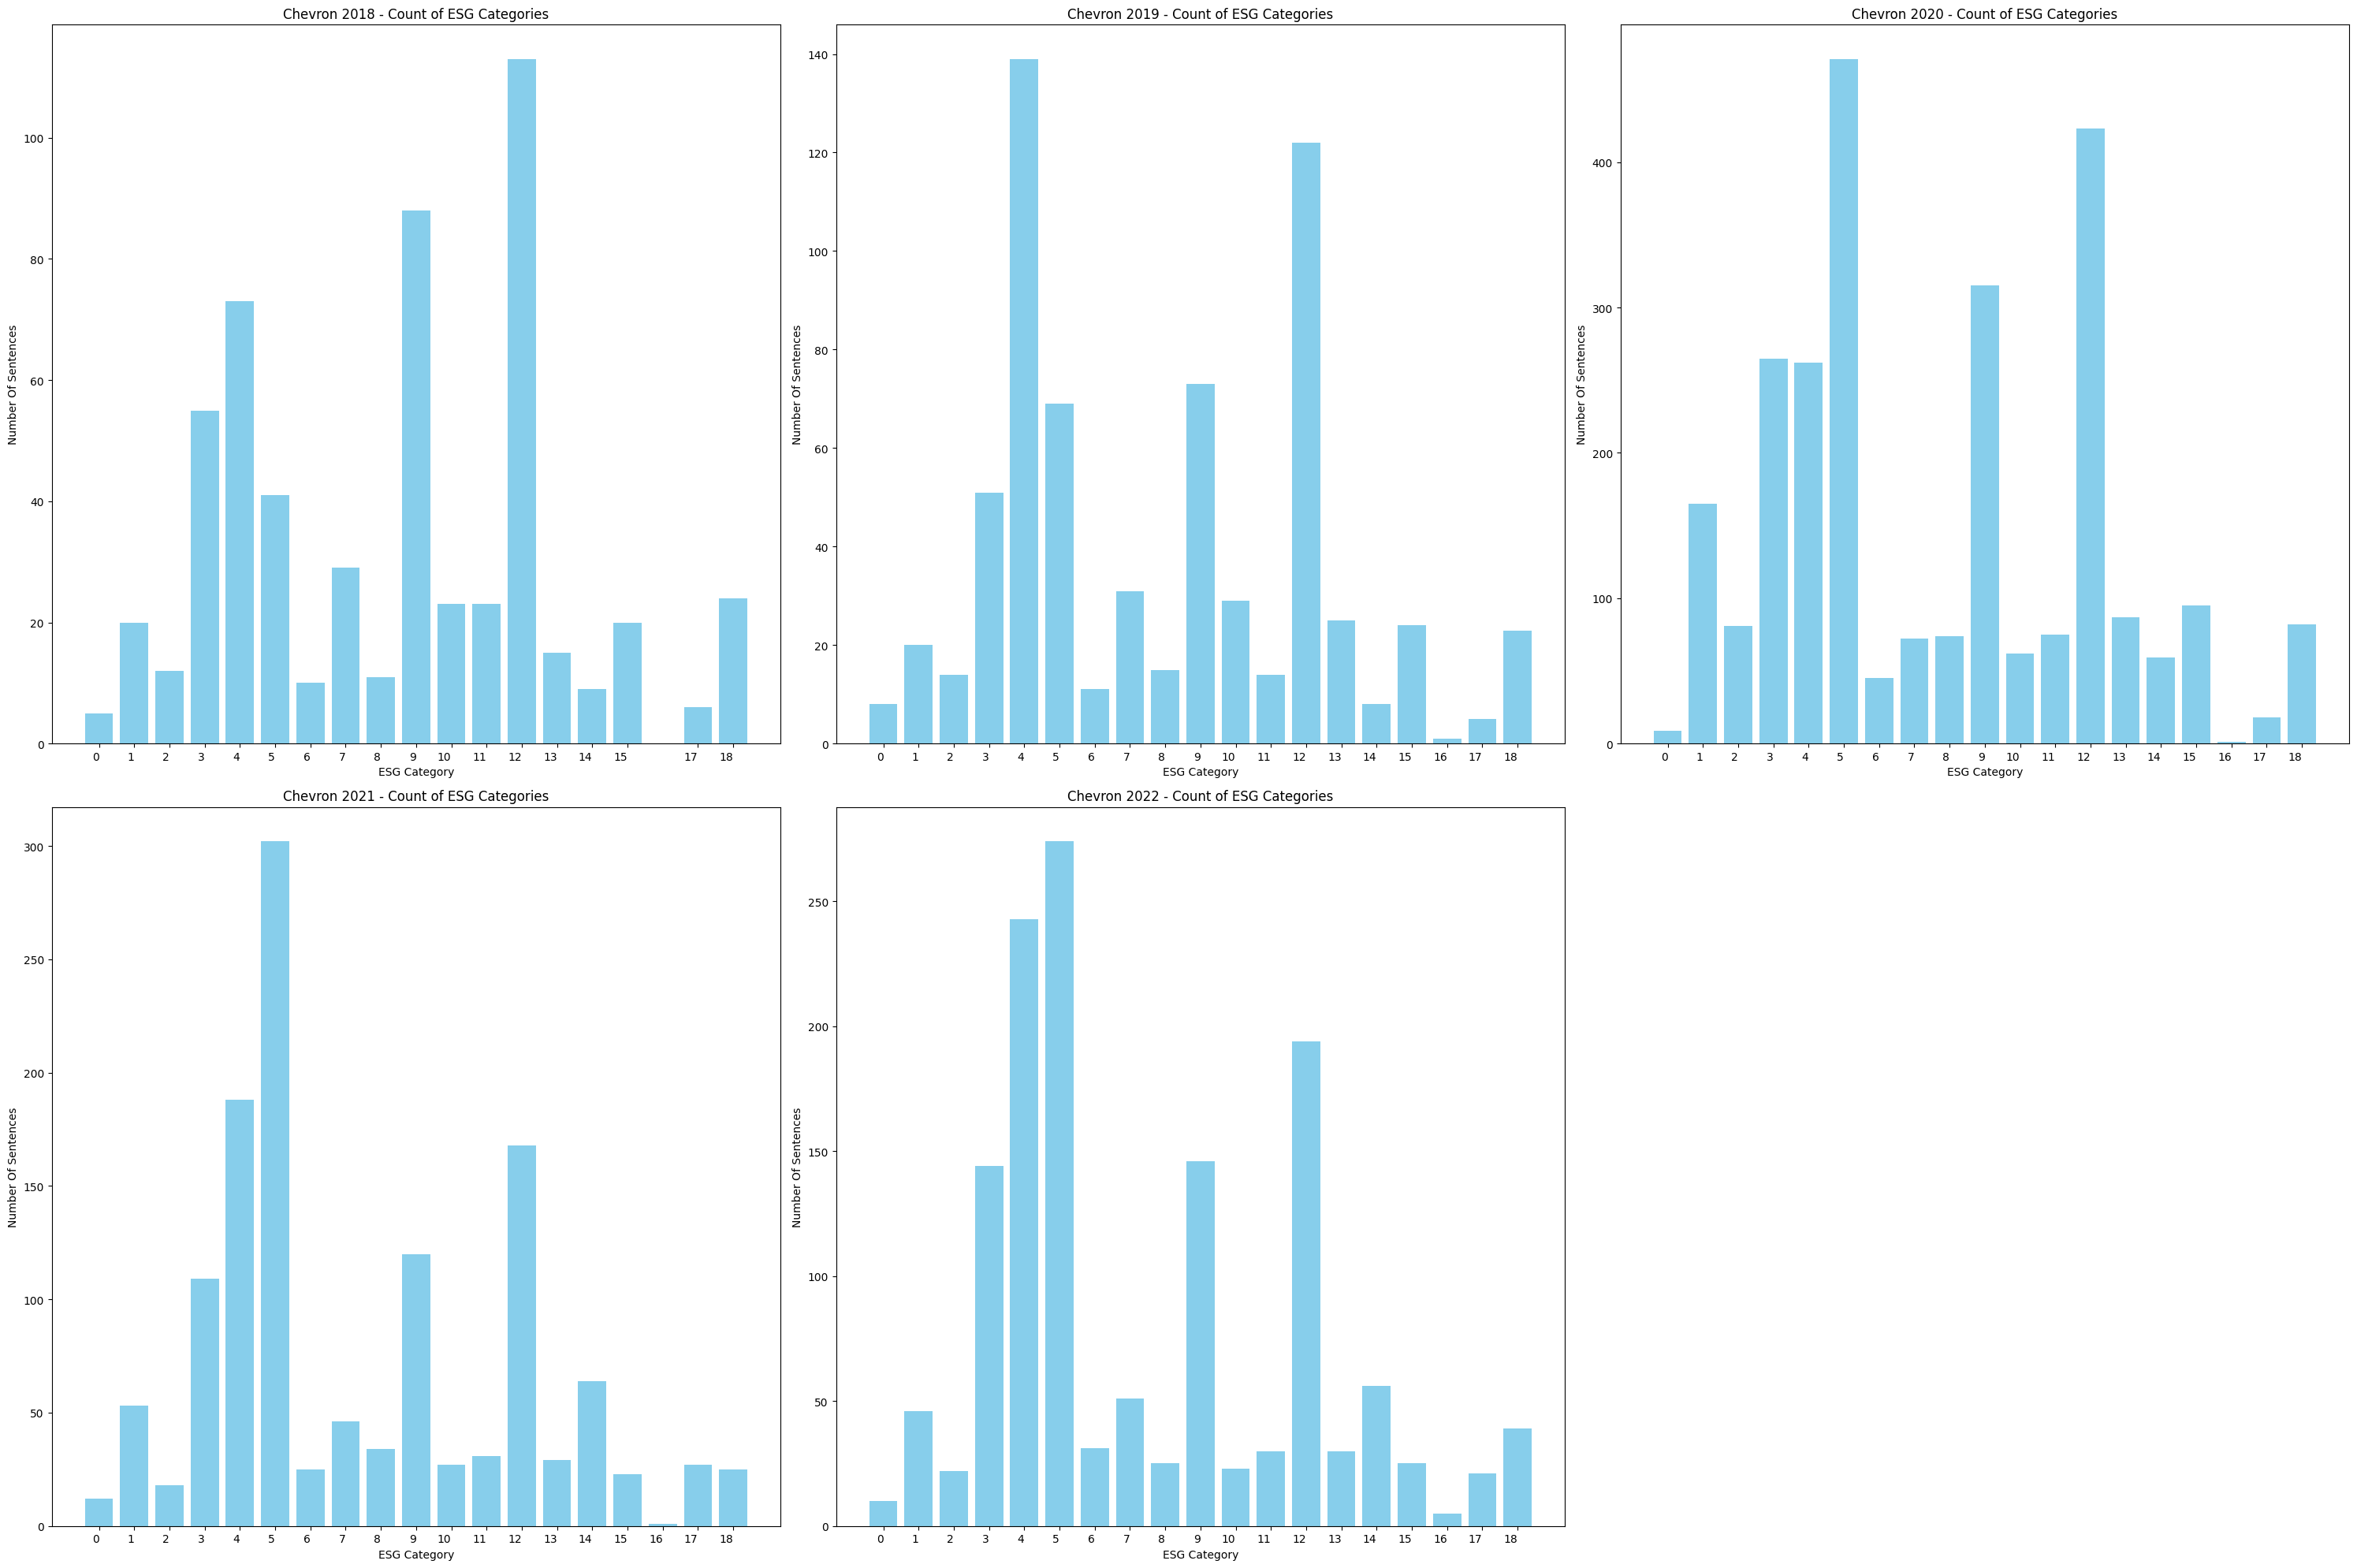

In [ ]:
plot_all(chevron_2022_df_id, chevron_name22_label, chevron_2021_df_id, chevron_name21_label, chevron_2020_df_id, chevron_name20_label, chevron_2019_df_id, chevron_name19_label, chevron_2018_df_id, chevron_name18_label)

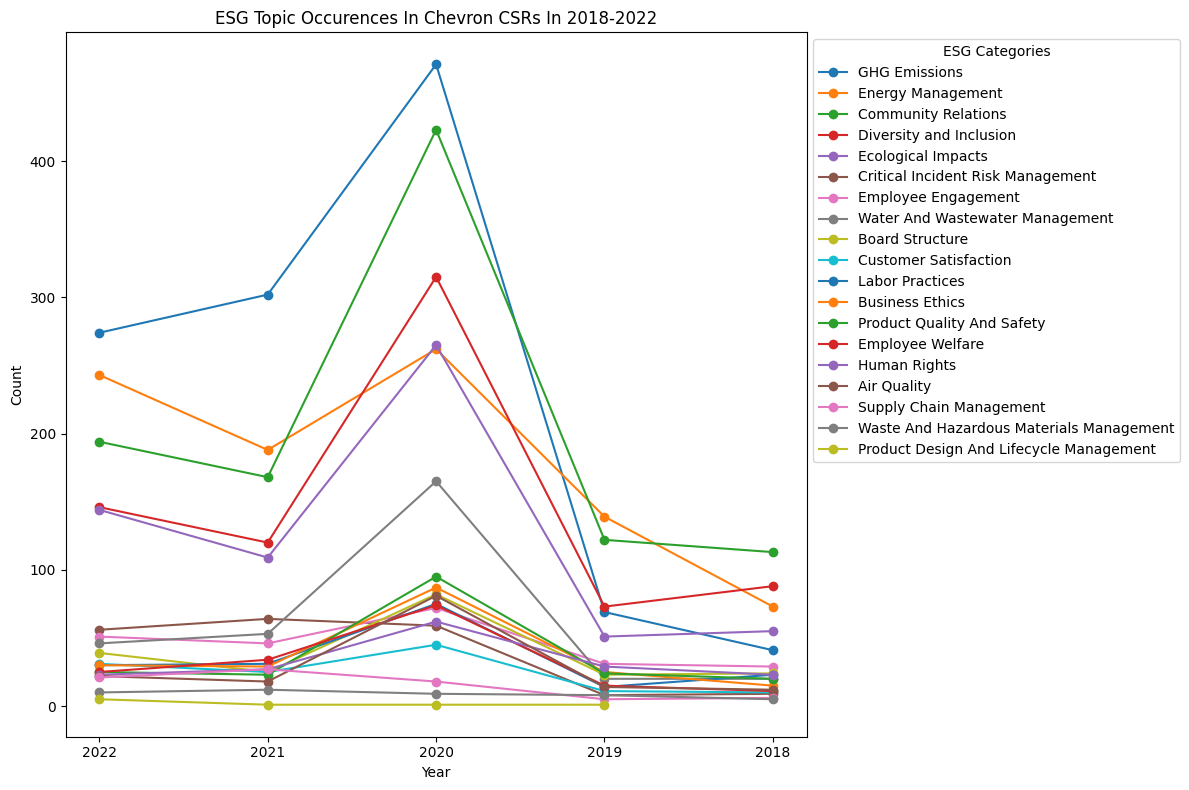

In [ ]:
chevron_dfs = [
    chevron_2022_df,
    chevron_2021_df,
    chevron_2020_df,
    chevron_2019_df,
    chevron_2018_df
]

plot_label_evolution(chevron_dfs, "ESG Topic Occurences In Chevron CSRs In 2018-2022")





# **General Motors**


---



***2022***

In [ ]:
gm_2022_df = analyze_report("General Motors", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/General Motors/GeneralMotors_2022.pdf")

In [ ]:
gm_2022_df['statements'] = gm_2022_df['statements'].apply(remove_illegal_chars)
gm_2022_df.to_excel('gm_2022.xlsx')
files.download('gm_2022.xlsx')
gm_2022_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2022.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name22_label = "General Motors 2022 - Count of ESG Categories"
gm_name22_esg = "General Motors 2022 - ESG Distribution"

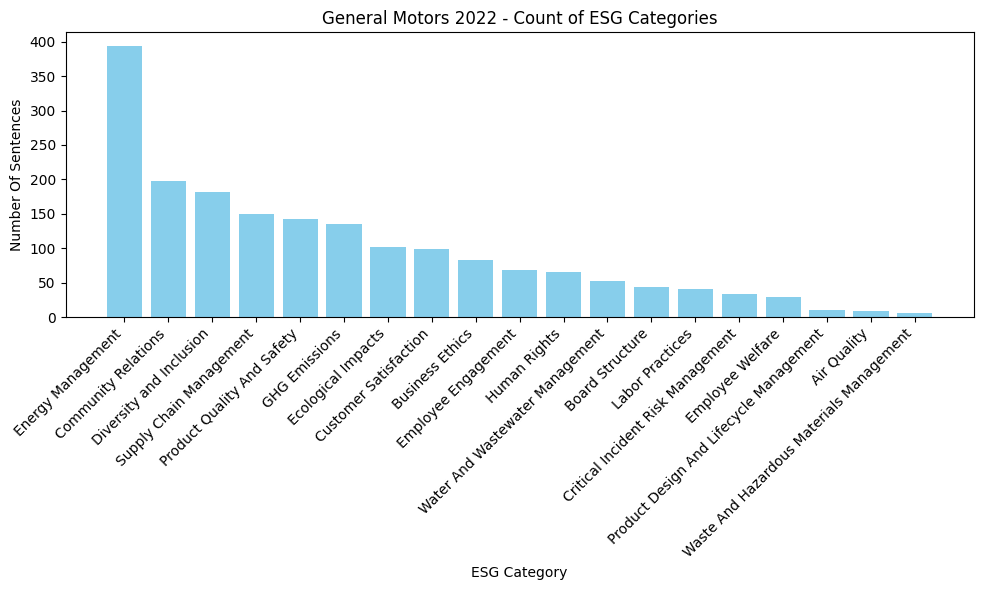

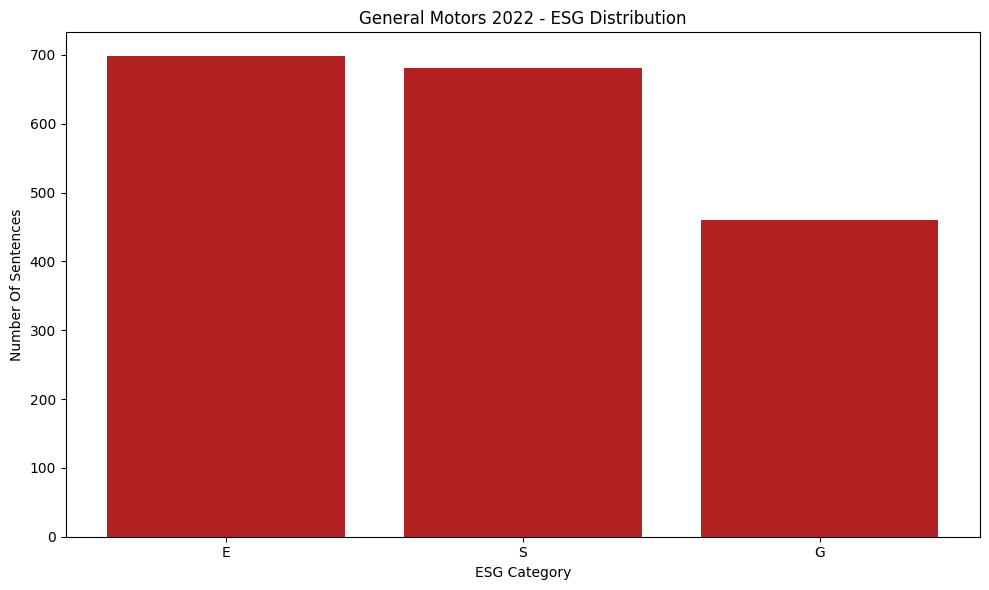

In [ ]:
plot_report(gm_2022_df, gm_name22_label, gm_name22_esg)

***2021***

In [ ]:
gm_2021_df = analyze_report("General Motors", "2021", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/General Motors/GeneralMotors_2021.pdf")

In [ ]:
gm_2021_df['statements'] = gm_2021_df['statements'].apply(remove_illegal_chars)
gm_2021_df.to_excel('gm_2021.xlsx')
files.download('gm_2021.xlsx')
gm_2021_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2021.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name21_label = "General Motors 2021 - Count of ESG Categories"
gm_name21_esg = "General Motors 2021 - ESG Distribution"

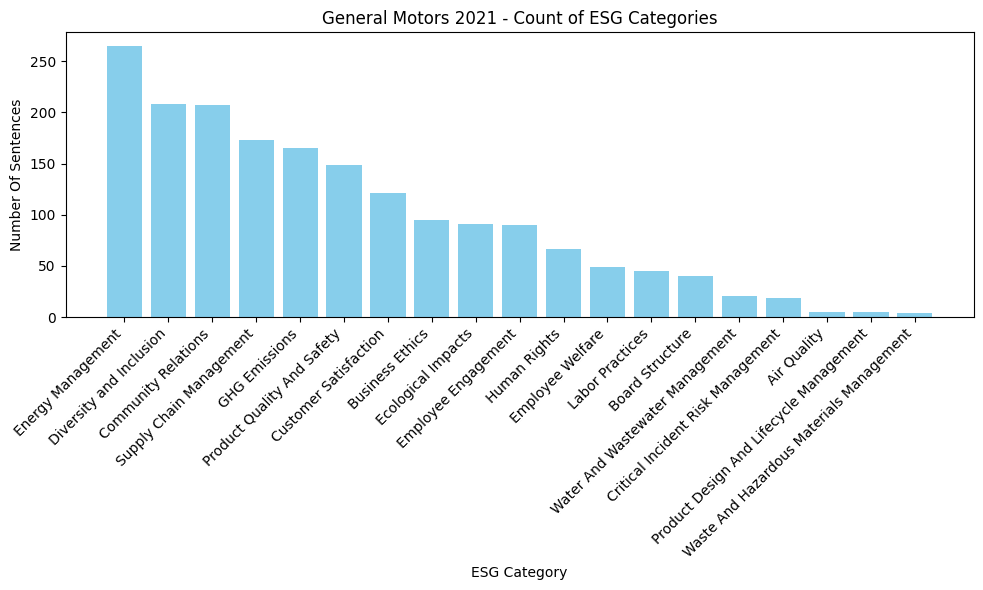

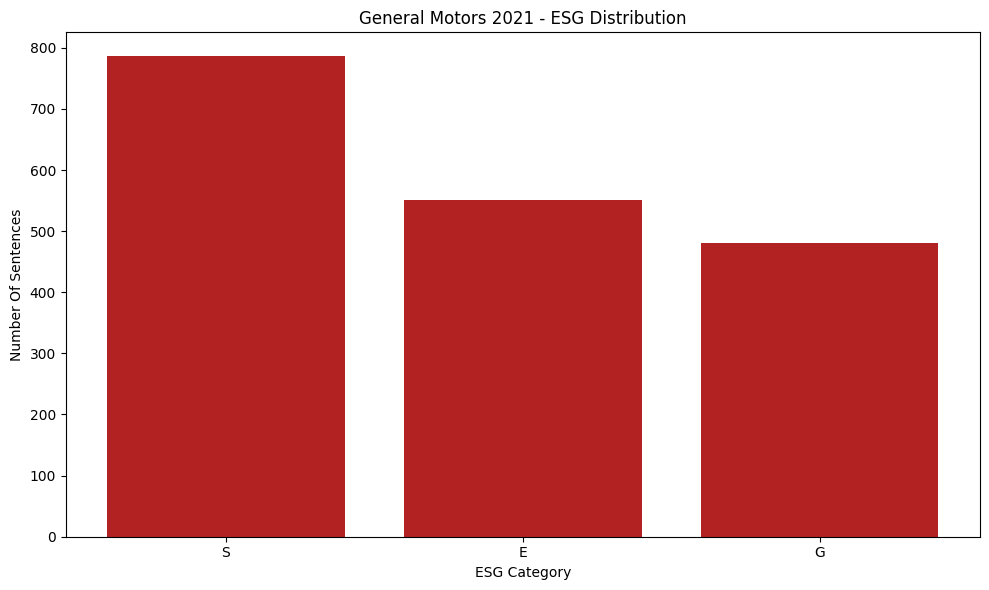

In [ ]:
plot_report(gm_2021_df, gm_name21_label, gm_name21_esg)

***2020***

In [ ]:
gm_2020_df = analyze_report("General Motors", "2020", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/General Motors/GeneralMotors_2020.pdf")

In [ ]:
gm_2020_df['statements'] = gm_2020_df['statements'].apply(remove_illegal_chars)
gm_2020_df.to_excel('gm_2020.xlsx')
files.download('gm_2020.xlsx')
gm_2020_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2020.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name20_label = "General Motors 2020 - Count of ESG Categories"
gm_name20_esg = "General Motors 2020 - ESG Distribution"

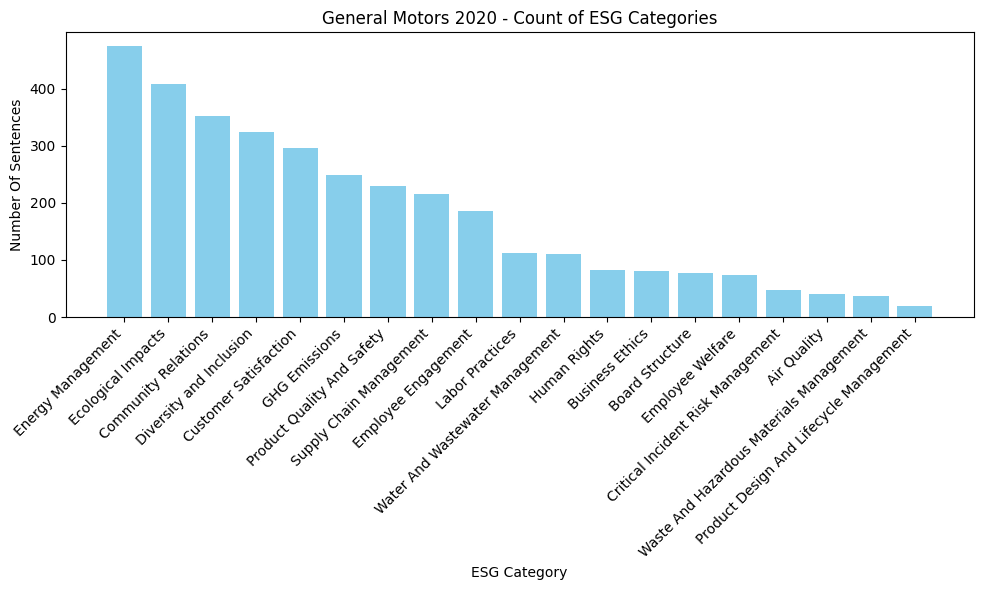

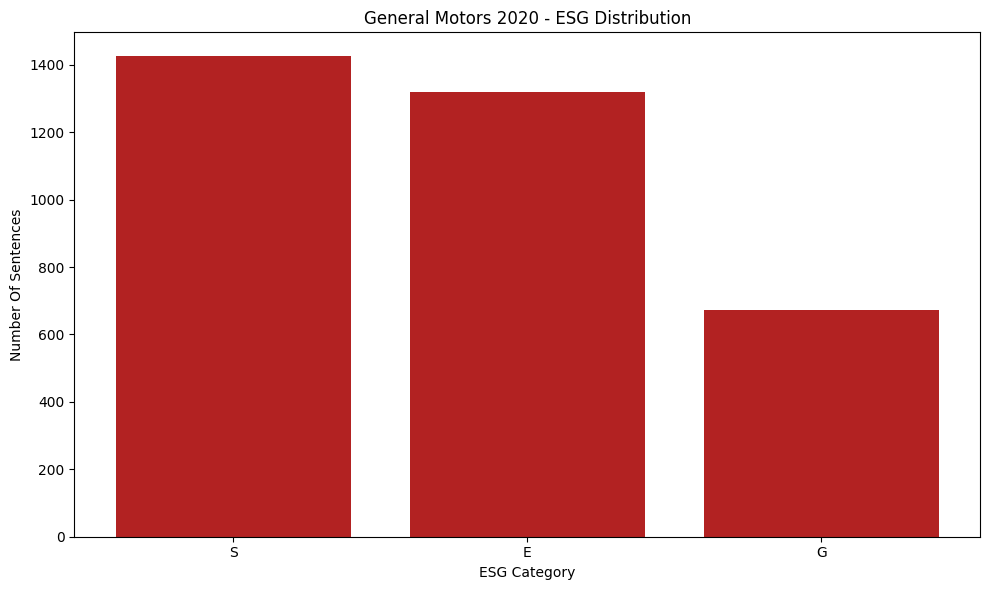

In [ ]:
plot_report(gm_2020_df, gm_name20_label, gm_name20_esg)

***2019***

In [ ]:
gm_2019_df = analyze_report("General Motors", "2019", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/General Motors/GeneralMotors_2019.pdf")

In [ ]:
gm_2019_df['statements'] = gm_2019_df['statements'].apply(remove_illegal_chars)
gm_2019_df.to_excel('gm_2019.xlsx')
files.download('gm_2019.xlsx')
gm_2019_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2019.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name19_label = "General Motors 2019 - Count of ESG Categories"
gm_name19_esg = "General Motors 2019 - ESG Distribution"

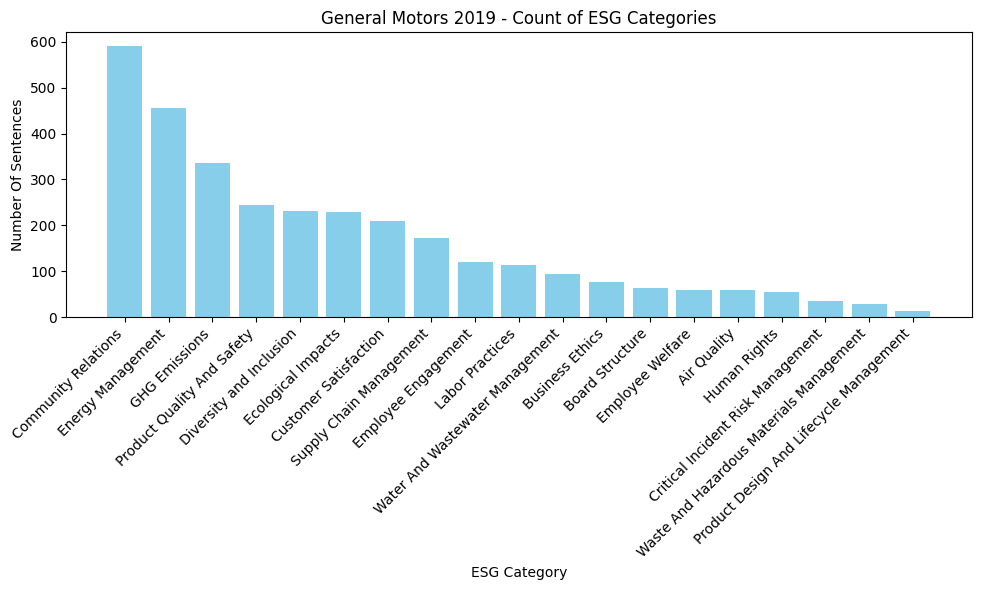

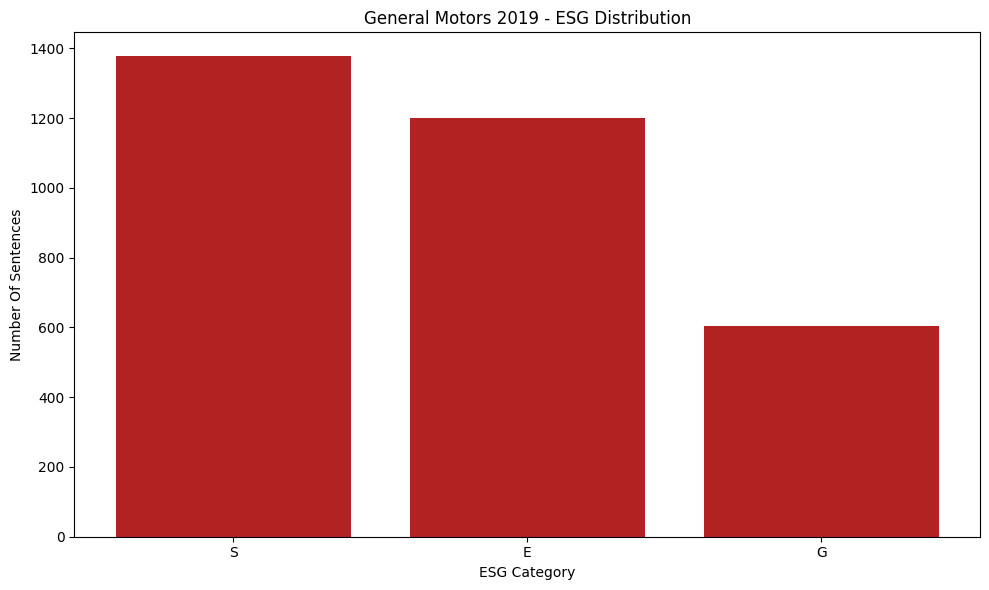

In [ ]:
plot_report(gm_2019_df, gm_name19_label, gm_name19_esg)

***2018***

In [ ]:
gm_2018_df = analyze_report("General Motors", "2018", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/General Motors/GeneralMotors_2018.pdf")

In [ ]:
gm_2018_df['statements'] = gm_2018_df['statements'].apply(remove_illegal_chars)
gm_2018_df.to_excel('gm_2018.xlsx')
files.download('gm_2018.xlsx')
gm_2018_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2018.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name18_label = "General Motors 2018 - Count of ESG Categories"
gm_name18_esg = "General Motors 2018 - ESG Distribution"

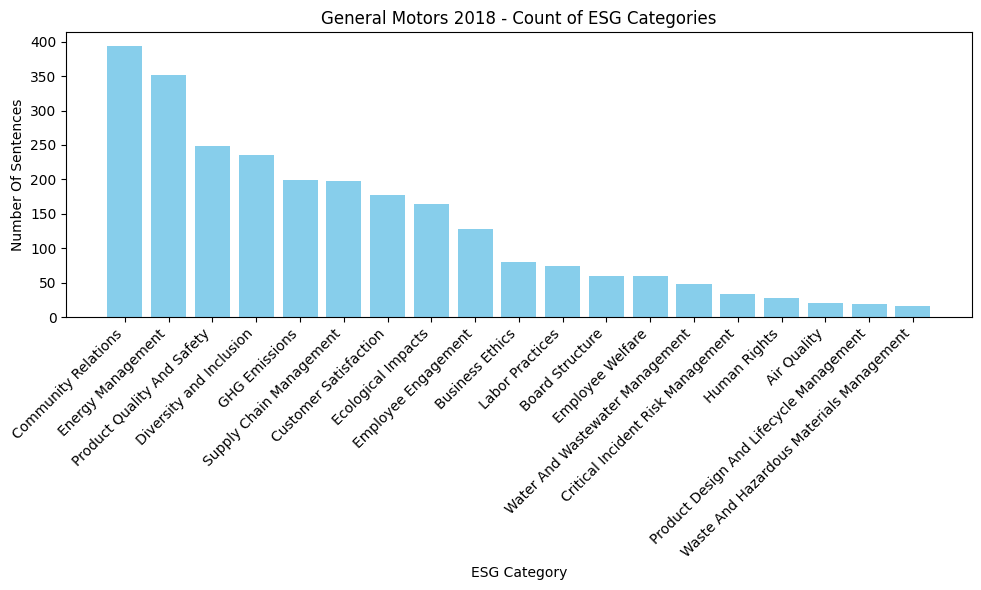

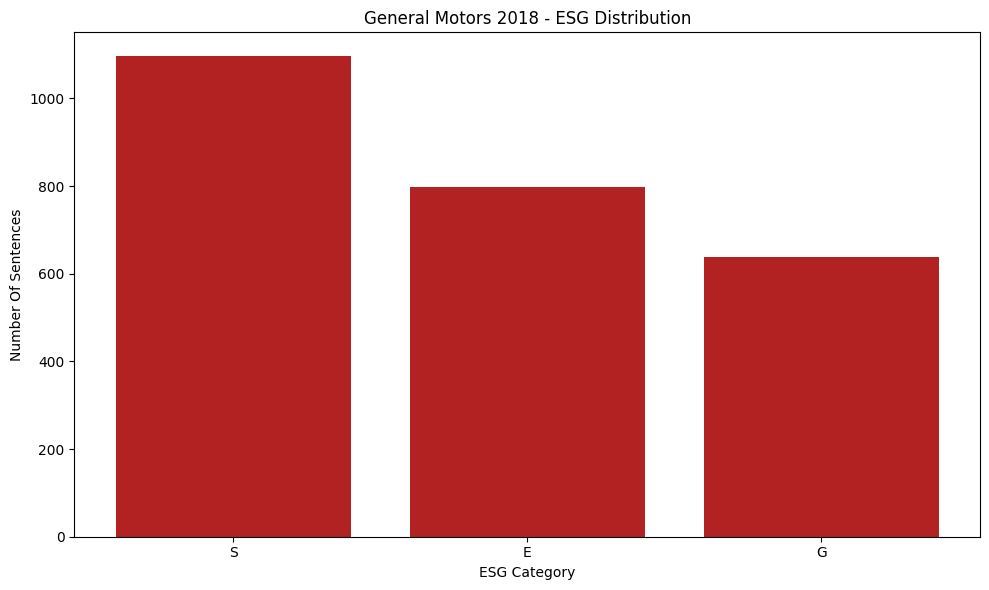

In [ ]:
plot_report(gm_2018_df, gm_name18_label, gm_name18_esg)

***Comparison***

In [ ]:
gm_2022_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2022.xlsx")
gm_2021_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2021.xlsx")
gm_2020_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2020.xlsx")
gm_2019_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2019.xlsx")
gm_2018_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/General Motors/gm_2018.xlsx")

In [ ]:
gm_2022_df_id = count_id(gm_2022_df)
gm_2021_df_id = count_id(gm_2021_df)
gm_2020_df_id = count_id(gm_2020_df)
gm_2019_df_id = count_id(gm_2019_df)
gm_2018_df_id = count_id(gm_2018_df)

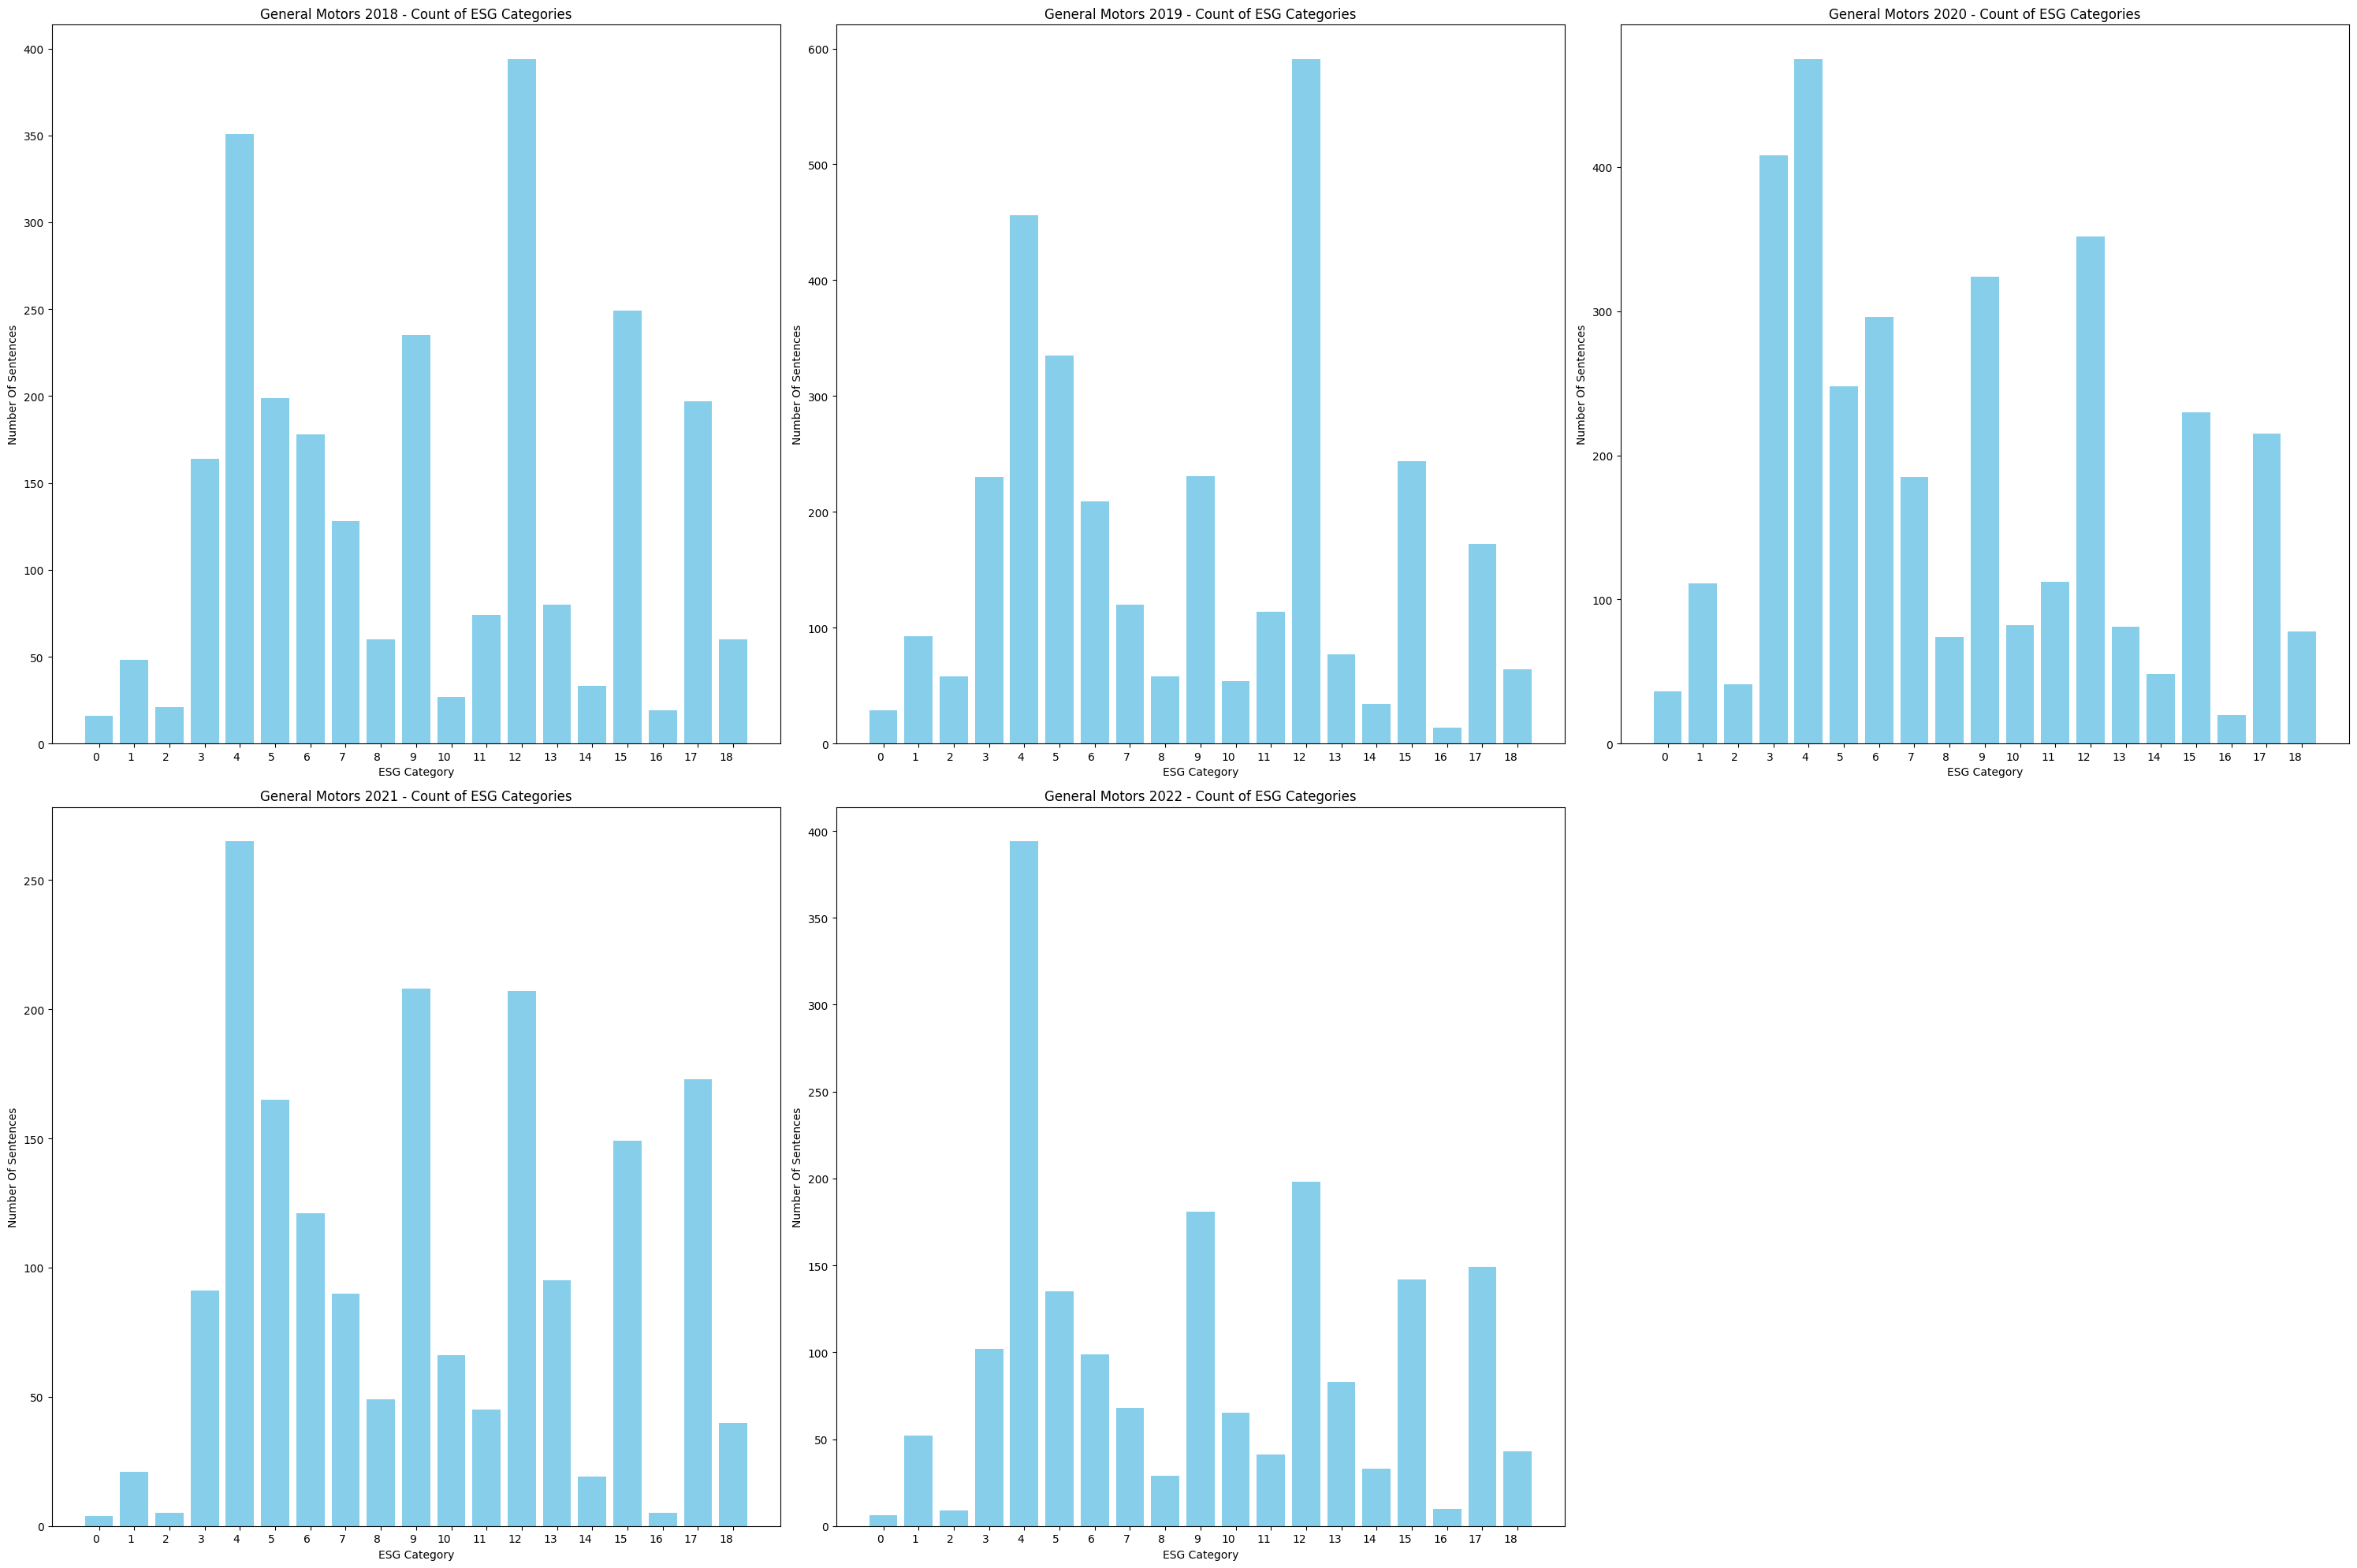

In [ ]:
plot_all(gm_2022_df_id, gm_name22_label, gm_2021_df_id, gm_name21_label, gm_2020_df_id, gm_name20_label, gm_2019_df_id, gm_name19_label, gm_2018_df_id, gm_name18_label)

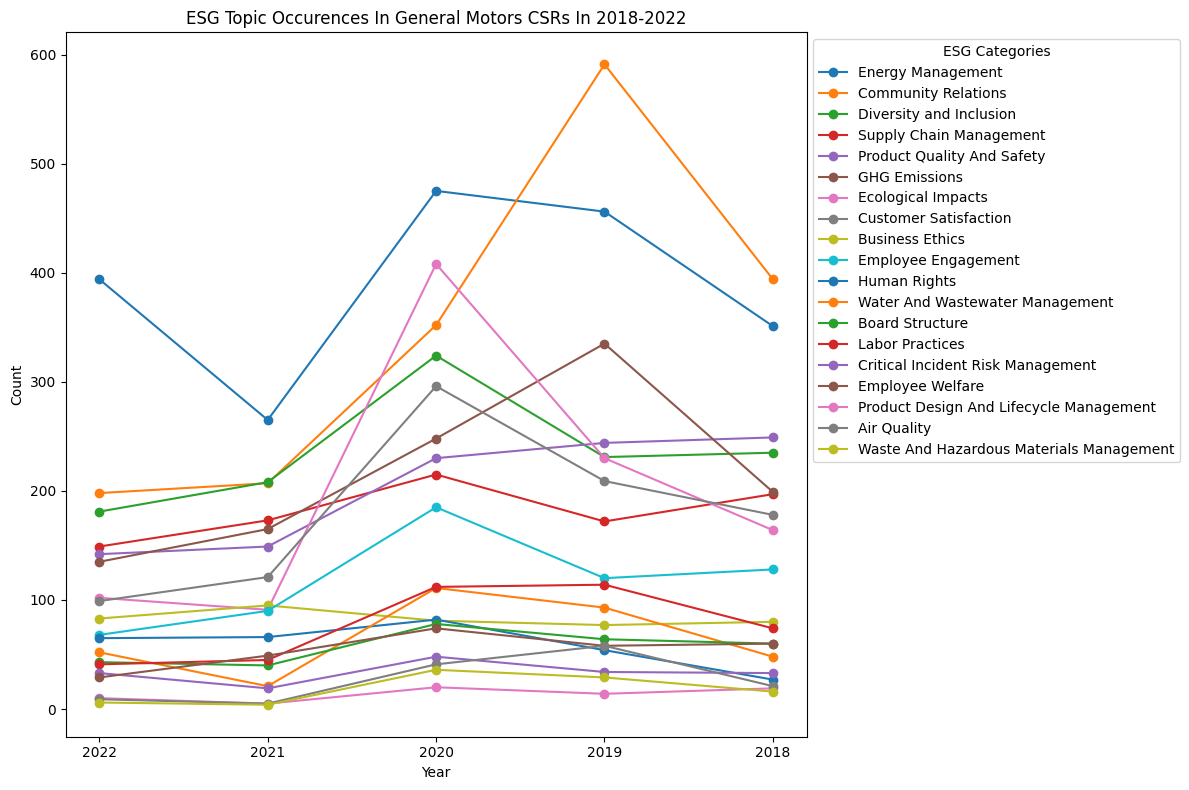

In [ ]:
gm_dfs = [
    gm_2022_df,
    gm_2021_df,
    gm_2020_df,
    gm_2019_df,
    gm_2018_df
]

plot_label_evolution(gm_dfs, "ESG Topic Occurences In General Motors CSRs In 2018-2022")





# **JP Morgan**


---



***2022***

In [ ]:
jpm_2022_df = analyze_report("JP Morgan", "2022", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/JP Morgan/JPMorgan_2022.pdf")

In [ ]:
jpm_2022_df['statements'] = jpm_2022_df['statements'].apply(remove_illegal_chars)
jpm_2022_df.to_excel('jpm_2022.xlsx')
files.download('jpm_2022.xlsx')
jpm_2022_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2022.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name22_label = "JP Morgan 2022 - Count of ESG Categories"
jpm_name22_esg = "JP Morgan 2022 - ESG Distribution"

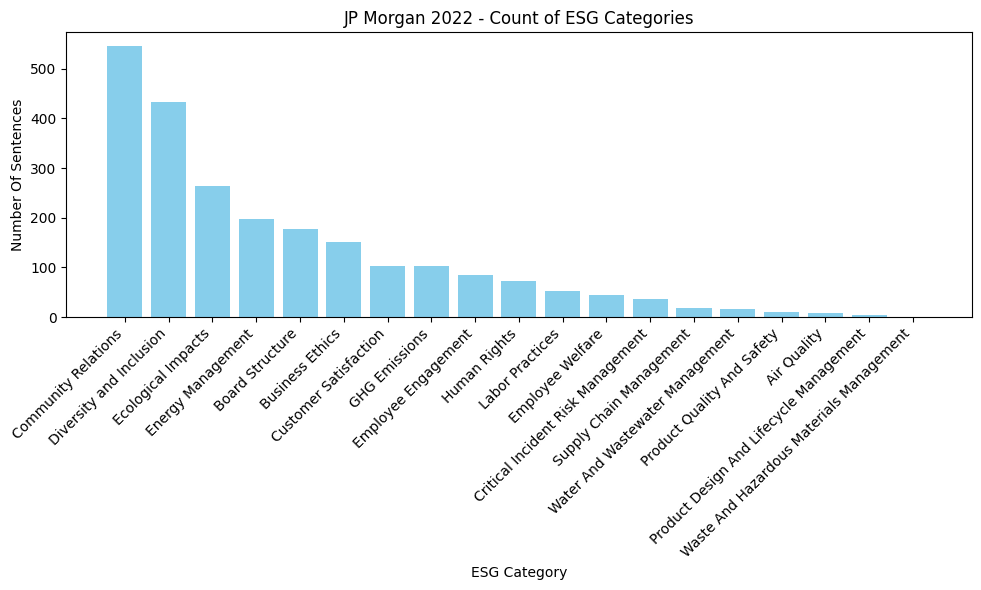

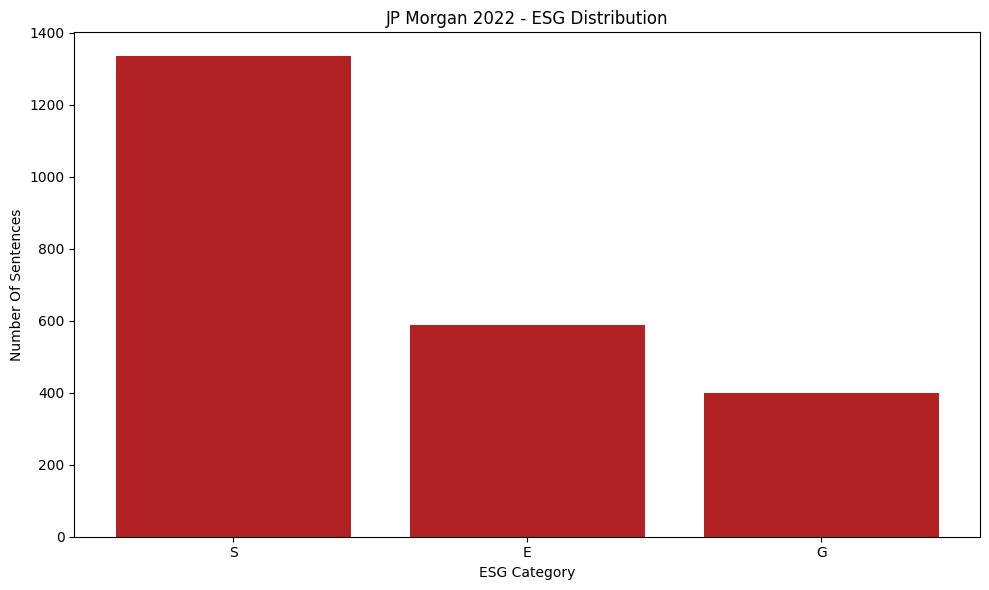

In [ ]:
plot_report(jpm_2022_df, jpm_name22_label, jpm_name22_esg)

***2021***

In [ ]:
jpm_2021_df = analyze_report("JP Morgan", "2021", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/JP Morgan/JPMorgan_2021.pdf")

In [ ]:
jpm_2021_df['statements'] = jpm_2021_df['statements'].apply(remove_illegal_chars)
jpm_2021_df.to_excel('jpm_2021.xlsx')
files.download('jpm_2021.xlsx')
jpm_2021_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2021.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name21_label = "JP Morgan 2021 - Count of ESG Categories"
jpm_name21_esg = "JP Morgan 2021 - ESG Distribution"

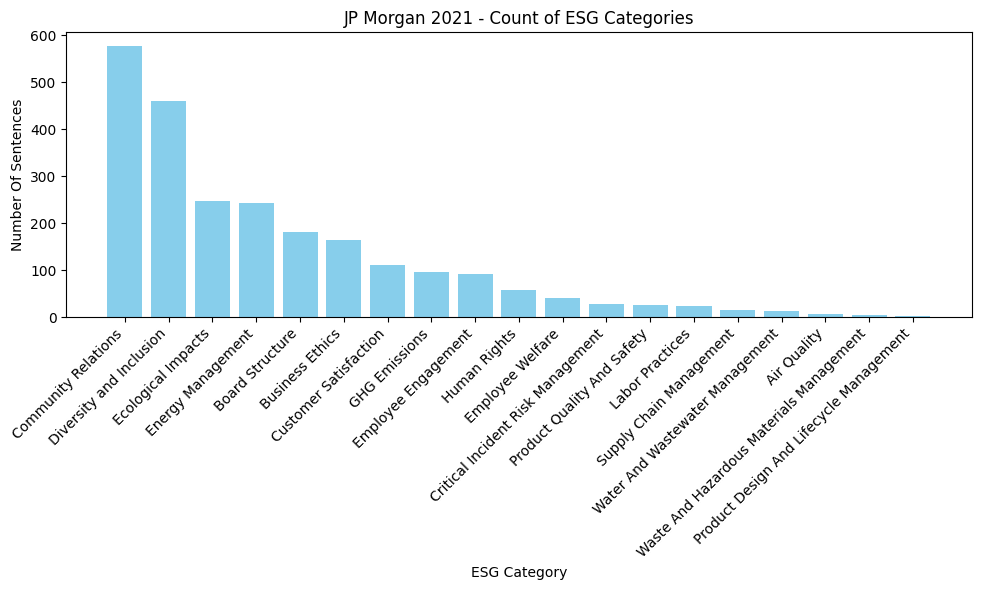

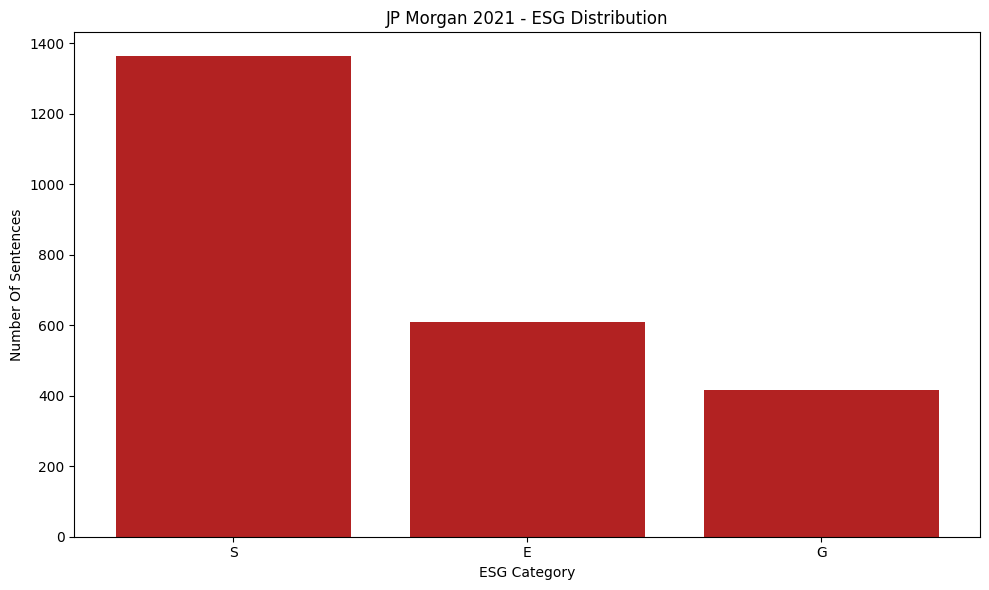

In [ ]:
plot_report(jpm_2021_df, jpm_name21_label, jpm_name21_esg)

***2020***

In [ ]:
jpm_2020_df = analyze_report("JP Morgan", "2020", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/JP Morgan/JPMorgan_2020.pdf")

In [ ]:
jpm_2020_df['statements'] = jpm_2020_df['statements'].apply(remove_illegal_chars)
jpm_2020_df.to_excel('jpm_2020.xlsx')
files.download('jpm_2020.xlsx')
jpm_2020_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2020.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name20_label = "JP Morgan 2020 - Count of ESG Categories"
jpm_name20_esg = "JP Morgan 2020 - ESG Distribution"

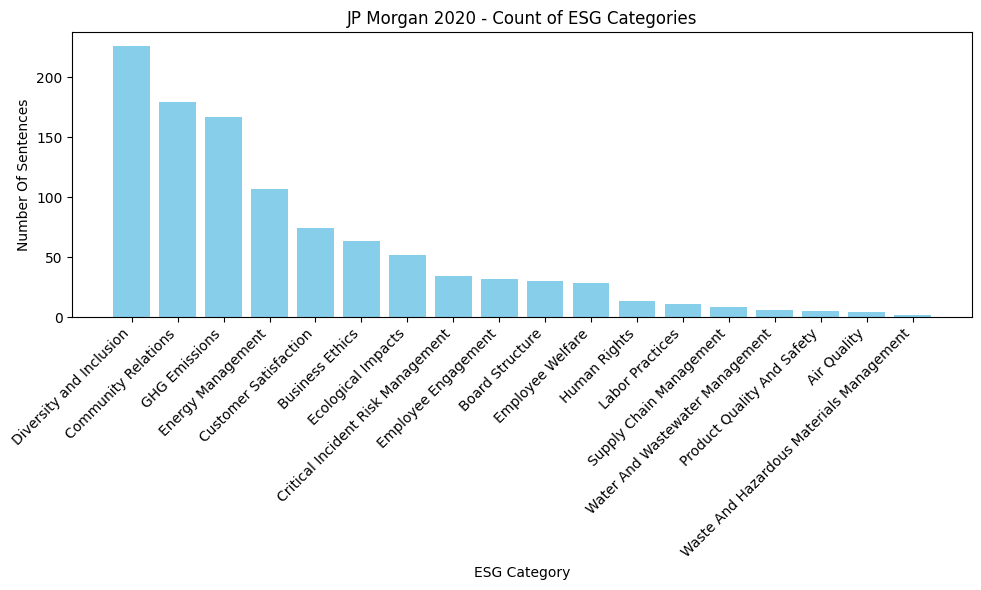

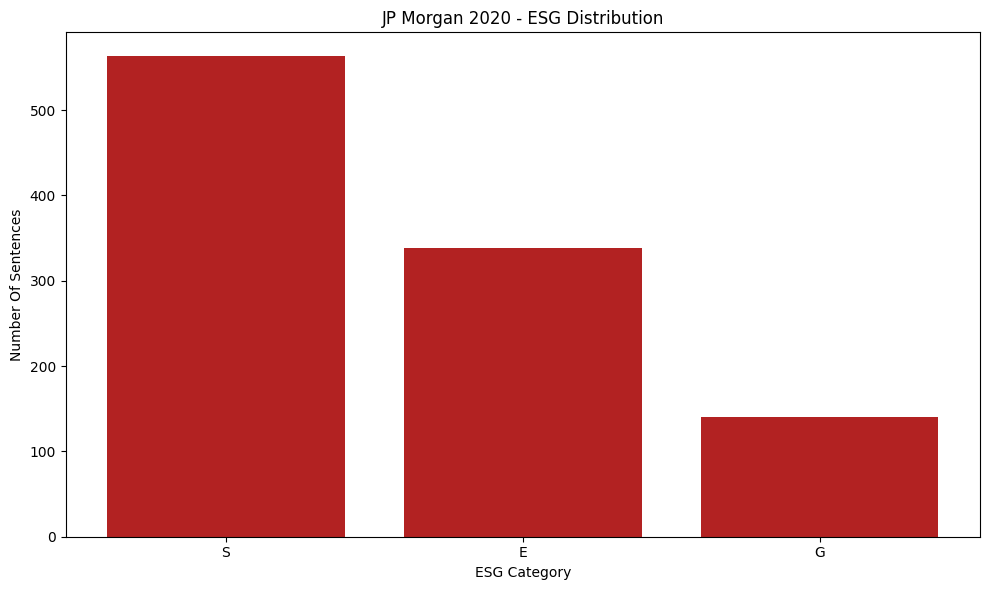

In [ ]:
plot_report(jpm_2020_df, jpm_name20_label, jpm_name20_esg)

***2019***

In [ ]:
jpm_2019_df = analyze_report("JP Morgan", "2019", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/JP Morgan/JPMorgan_2019.pdf")

In [ ]:
jpm_2019_df['statements'] = jpm_2019_df['statements'].apply(remove_illegal_chars)
jpm_2019_df.to_excel('jpm_2019.xlsx')
files.download('jpm_2019.xlsx')
jpm_2019_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2019.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name19_label = "JP Morgan 2019 - Count of ESG Categories"
jpm_name19_esg = "JP Morgan 2019 - ESG Distribution"

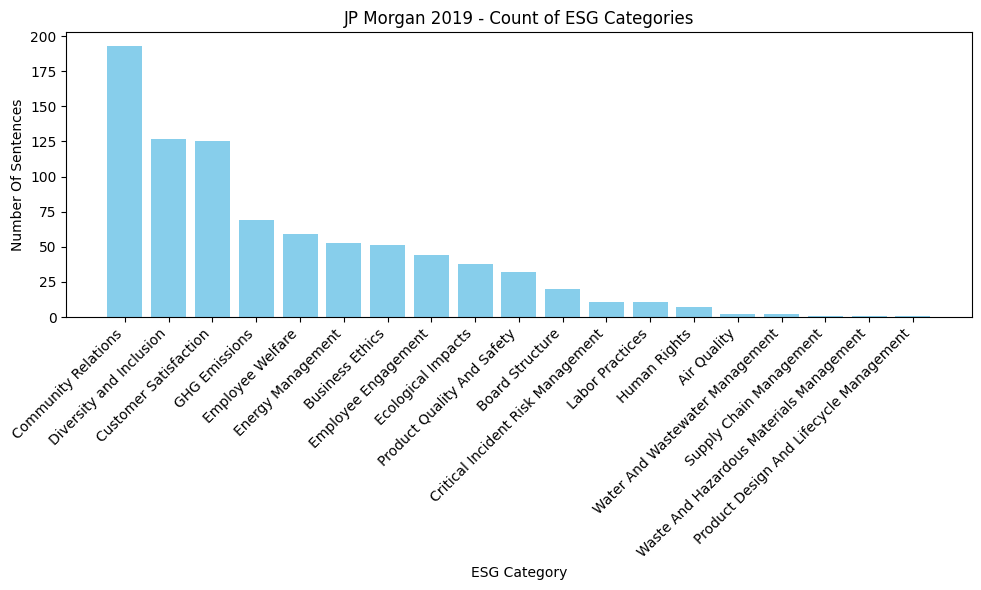

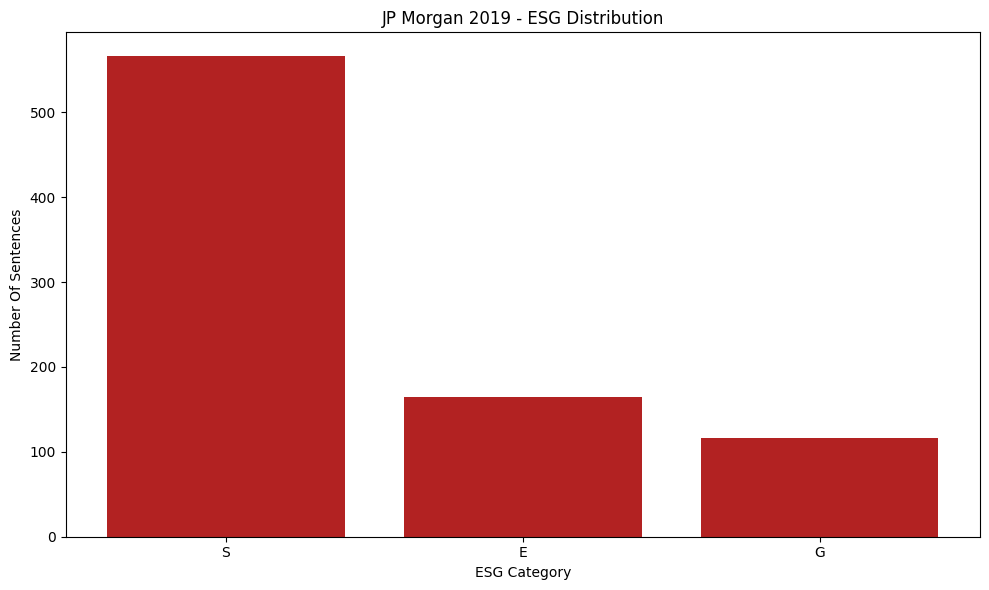

In [ ]:
plot_report(jpm_2019_df, jpm_name19_label, jpm_name19_esg)

***2018***

In [ ]:
jpm_2018_df = analyze_report("JP Morgan", "2018", "/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/PDF/JP Morgan/JPMorgan_2018.pdf")

In [ ]:
jpm_2018_df['statements'] = jpm_2018_df['statements'].apply(remove_illegal_chars)
jpm_2018_df.to_excel('jpm_2018.xlsx')
files.download('jpm_2018.xlsx')
jpm_2018_df.to_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2018.xlsx")

In [ ]:
jpm_name18_label = "JP Morgan 2018 - Count of ESG Categories"
jpm_name18_esg = "JP Morgan 2018 - ESG Distribution"

In [ ]:
plot_report(jpm_2018_df, jpm_name18_label, jpm_name18_esg)

***Comparison***

In [ ]:
jpm_2022_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2022.xlsx")
jpm_2021_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2021.xlsx")
jpm_2020_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2020.xlsx")
jpm_2019_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2019.xlsx")
jpm_2018_df = pd.read_excel("/content/drive/My Drive/CSR ANALYSIS PROJECT/Project Data/EXCEL v3 (current)/JP Morgan/jpm_2018.xlsx")

In [ ]:
jpm_2022_df_id = count_id(jpm_2022_df)
jpm_2021_df_id = count_id(jpm_2021_df)
jpm_2020_df_id = count_id(jpm_2020_df)
jpm_2019_df_id = count_id(jpm_2019_df)
jpm_2018_df_id = count_id(jpm_2018_df)

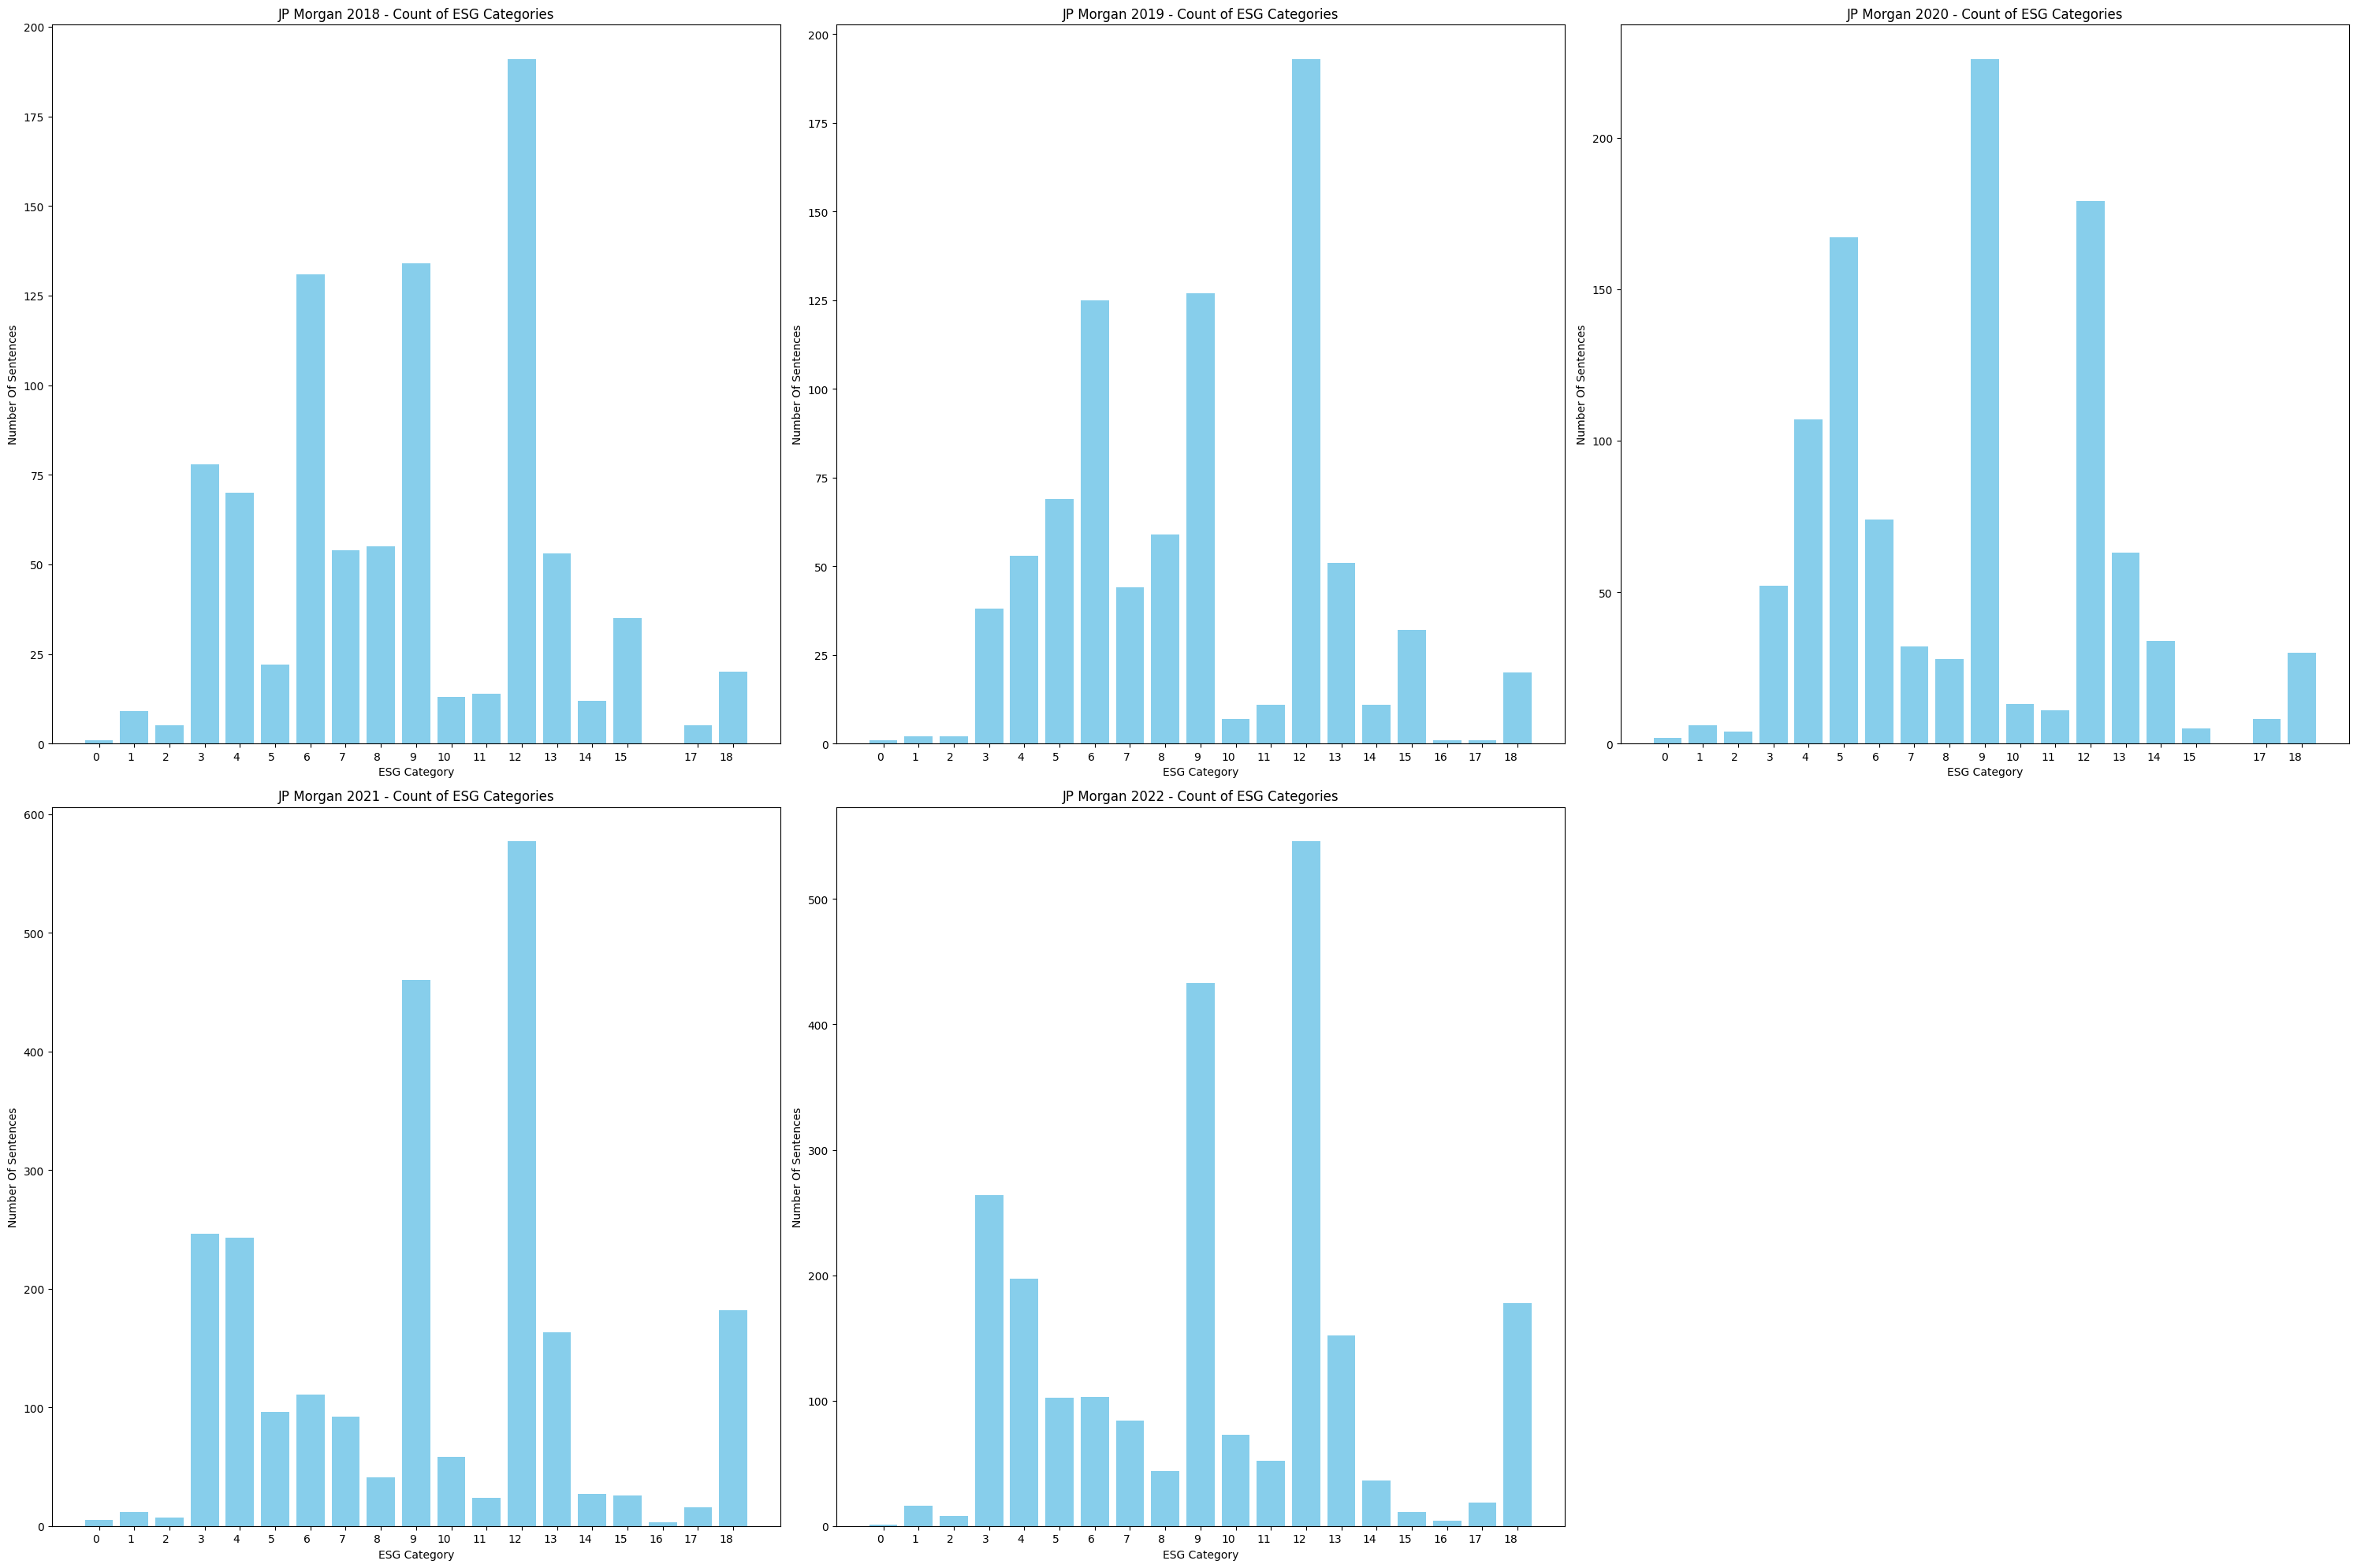

In [ ]:
plot_all(jpm_2022_df_id, jpm_name22_label, jpm_2021_df_id, jpm_name21_label, jpm_2020_df_id, jpm_name20_label, jpm_2019_df_id, jpm_name19_label, jpm_2018_df_id, jpm_name18_label)

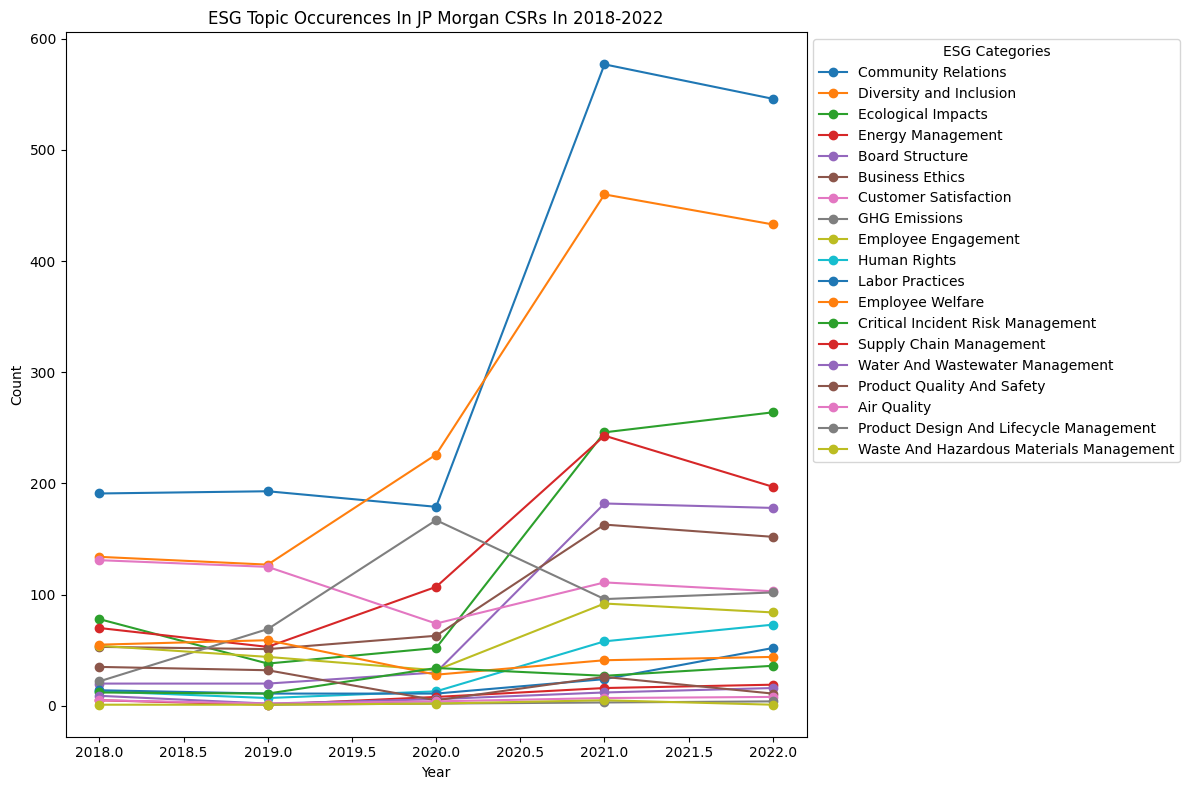

In [ ]:
jpm_dfs = [
    jpm_2022_df,
    jpm_2021_df,
    jpm_2020_df,
    jpm_2019_df,
    jpm_2018_df
]

plot_label_evolution(jpm_dfs, "ESG Topic Occurences In JP Morgan CSRs In 2018-2022")